In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices("GPU"))

2024-02-22 00:47:15.223876: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 00:47:15.223939: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 00:47:15.224876: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 00:47:15.231534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 00:47:16.434509: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-22 00:47:17.785459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:17.818588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:17.818880: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import pandas as pd

DATAPATH = "data"

df = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")
df["c"] = 0b000  # meat, veggie, noodle
df

filename  meat  veggie  noodle  c
0     0-food_tray-10-top.jpg     0       0       0  0
1     0-food_tray-12-top.jpg     0       0       0  0
2     0-food_tray-13-top.jpg     0       0       0  0
3     0-food_tray-14-top.jpg     0       0       0  0
4     0-food_tray-16-top.jpg     0       0       0  0
...                      ...   ...     ...     ... ..
1851  2020_09_18-266-top.jpg    15      15      60  0
1852  2020_09_18-267-top.jpg    15      15      60  0
1853  2020_09_18-268-top.jpg    15      15      60  0
1854  2020_09_18-269-top.jpg    15      15      60  0
1855  2020_09_18-270-top.jpg    15      15      60  0

[1856 rows x 5 columns]

In [4]:
df.loc[df["meat"] > 0, "c"] = df.loc[df["meat"] > 0, "c"] | 0b100
df.loc[df["veggie"] > 0, "c"] = df.loc[df["veggie"] > 0, "c"] | 0b010
df.loc[df["noodle"] > 0, "c"] = df.loc[df["noodle"] > 0, "c"] | 0b001
df["c"].value_counts()

c
7    891
2    254
3    247
1    158
4    129
6     96
5     57
0     24
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(df, train_size=0.8, stratify=df[['c']])

train_set['c'].value_counts(normalize=True).compare(validation_set['c'].value_counts(normalize=True))

self     other
c                    
7  0.479784  0.481183
2  0.136792  0.137097
3  0.133423  0.131720
1  0.084906  0.086022
4  0.069407  0.069892
6  0.051887  0.051075
5  0.030997  0.029570
0  0.012803  0.013441

In [6]:
# copying the data
# maybe it can be better if increase the target too

target = 100
l = train_set['c'].value_counts().copy()
for i, r in l.items():
    if r < target:
        c = r
        while (c < target):
            sampled_n = min(len(train_set[train_set["c"] == i]), (target-c))
            sampled = train_set[train_set["c"] == i].sample(n=sampled_n)
            train_set = pd.concat([train_set, sampled], ignore_index=True)
            c += sampled_n

train_set["c"].value_counts(), len(train_set)

(c
 7    712
 2    203
 3    198
 1    126
 4    103
 0    100
 5    100
 6    100
 Name: count, dtype: int64,
 1642)

In [7]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

img_size = (300, 500)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(img_size[0], img_size[1]),
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    shuffle=False,
    target_size=(img_size[0], img_size[1]),
)

Found 1642 validated image filenames.
Found 372 validated image filenames.


# MODEL DEF

This could've been better, maybe if we add more linear or non-linear layer

In [8]:
import keras
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
)
from keras.optimizers import Adam

base_model = keras.applications.ResNet50(
    weights="imagenet", input_shape=(img_size[0], img_size[1], 3), include_top=False
)
base_model.trainable = False

input = Input(
    shape=(
        img_size[0],
        img_size[1],
        3,
    )
)
x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
dense = Dense(256, activation='sigmoid')(x)
dense = Dropout(0.1)(dense)
dense = Dense(256, activation='sigmoid')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(256, activation='linear')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(256, activation='linear')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(128, activation='linear')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(128, activation='linear')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(64, activation='linear')(dense)
dense = Dropout(0.1)(dense)
dense = Dense(64, activation='linear')(dense)
dense = Dropout(0.1)(dense)
output = keras.layers.Dense(3, activation='linear')(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4), loss="mse", metrics="mean_absolute_error"
)
model.summary(show_trainable=True)

2024-02-22 00:47:18.566978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:18.567913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:18.568394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:18.846122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-22 00:47:18.846519: I external/local_xla/xla/stream_executor

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 300, 500, 3)]     0         Y          
                                                                            
 resnet50 (Functional)       (None, 10, 16, 2048)      2358771   N          
                                                       2                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dense (Dense)               (None, 256)               524544    Y          
                                                                            
 dropout (Dropout)           (None, 256)               0     

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

checkpoint = ModelCheckpoint(
    "temp-from-pre.keras",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 1355.9451 - mean_absolute_error: 23.0671
Epoch 1: val_mean_absolute_error did not improve from 24.40824


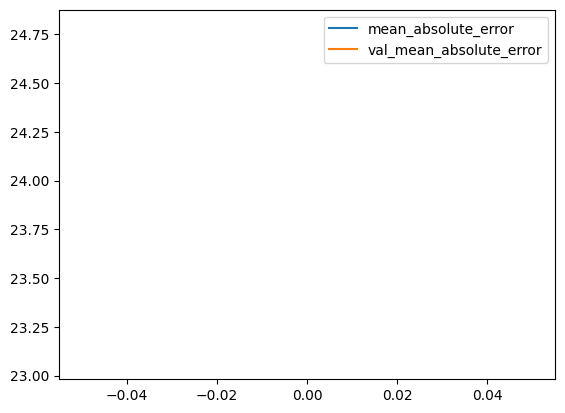

52/52 [==============================] - 10s 196ms/step - loss: 1355.9451 - mean_absolute_error: 23.0671 - val_loss: 1543.3254 - val_mean_absolute_error: 24.7896
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 1344.5302 - mean_absolute_error: 23.1660
Epoch 2: val_mean_absolute_error did not improve from 24.40824


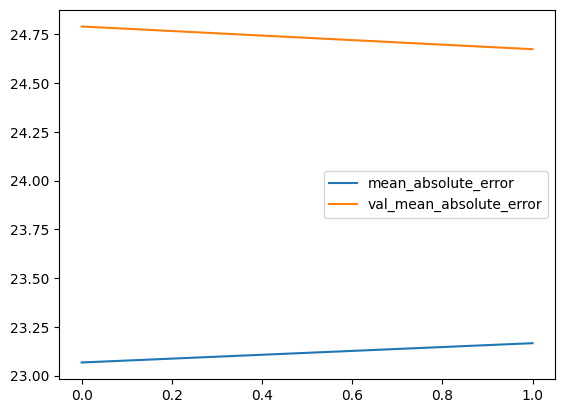

52/52 [==============================] - 10s 195ms/step - loss: 1344.5302 - mean_absolute_error: 23.1660 - val_loss: 1547.8950 - val_mean_absolute_error: 24.6732
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 1354.8545 - mean_absolute_error: 23.1423
Epoch 3: val_mean_absolute_error did not improve from 24.40824


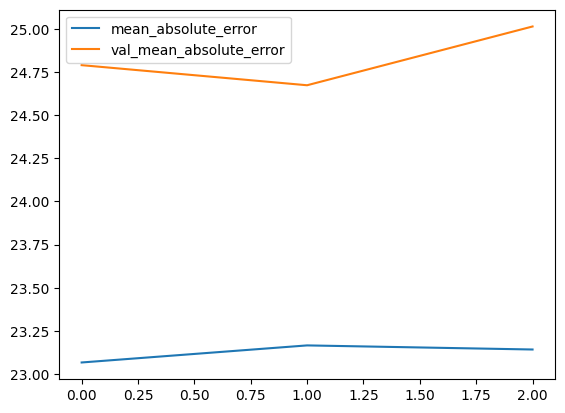

52/52 [==============================] - 11s 201ms/step - loss: 1354.8545 - mean_absolute_error: 23.1423 - val_loss: 1520.5809 - val_mean_absolute_error: 25.0137
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 1338.4642 - mean_absolute_error: 23.0036
Epoch 4: val_mean_absolute_error improved from 24.40824 to 24.33350, saving model to temp-from-pre.keras


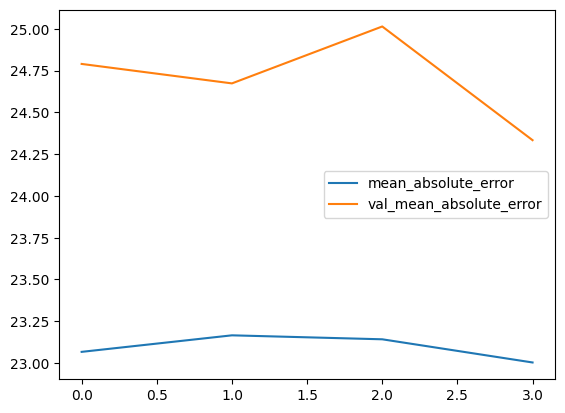

52/52 [==============================] - 11s 213ms/step - loss: 1338.4642 - mean_absolute_error: 23.0036 - val_loss: 1595.3302 - val_mean_absolute_error: 24.3335
Epoch 5/100
52/52 [==============================] - ETA: 0s - loss: 1346.4789 - mean_absolute_error: 22.9611
Epoch 5: val_mean_absolute_error did not improve from 24.33350


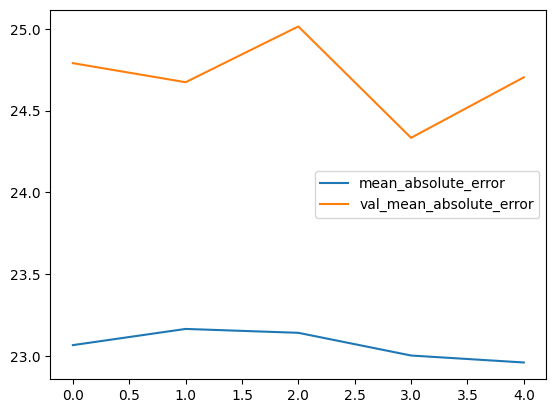

52/52 [==============================] - 10s 196ms/step - loss: 1346.4789 - mean_absolute_error: 22.9611 - val_loss: 1527.0192 - val_mean_absolute_error: 24.7032
Epoch 6/100
52/52 [==============================] - ETA: 0s - loss: 1337.7295 - mean_absolute_error: 23.2605
Epoch 6: val_mean_absolute_error improved from 24.33350 to 24.28715, saving model to temp-from-pre.keras


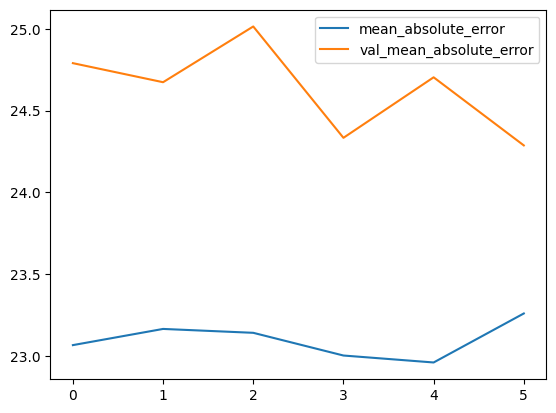

52/52 [==============================] - 11s 213ms/step - loss: 1337.7295 - mean_absolute_error: 23.2605 - val_loss: 1574.5991 - val_mean_absolute_error: 24.2871
Epoch 7/100
52/52 [==============================] - ETA: 0s - loss: 1341.6334 - mean_absolute_error: 22.6389
Epoch 7: val_mean_absolute_error did not improve from 24.28715


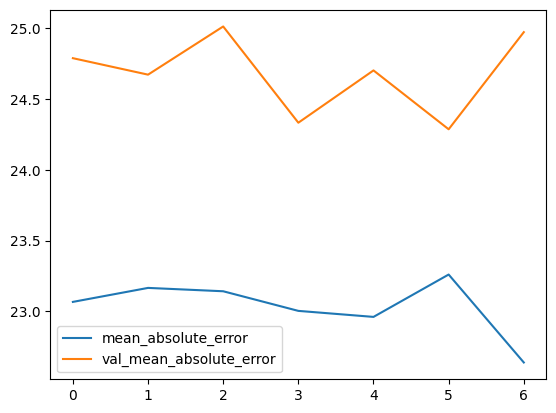

52/52 [==============================] - 10s 199ms/step - loss: 1341.6334 - mean_absolute_error: 22.6389 - val_loss: 1517.1923 - val_mean_absolute_error: 24.9736
Epoch 8/100
52/52 [==============================] - ETA: 0s - loss: 1337.9315 - mean_absolute_error: 23.0237
Epoch 8: val_mean_absolute_error did not improve from 24.28715


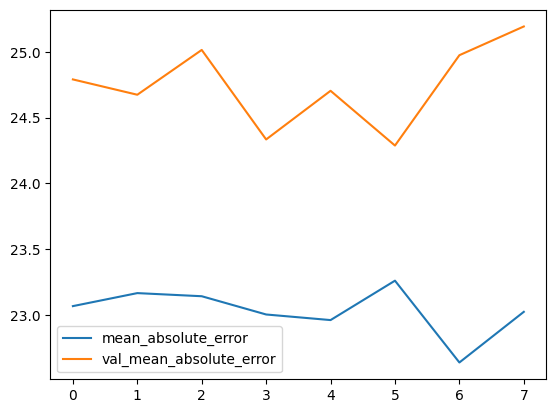

52/52 [==============================] - 10s 195ms/step - loss: 1337.9315 - mean_absolute_error: 23.0237 - val_loss: 1505.3152 - val_mean_absolute_error: 25.1919
Epoch 9/100
52/52 [==============================] - ETA: 0s - loss: 1331.4269 - mean_absolute_error: 22.8389
Epoch 9: val_mean_absolute_error did not improve from 24.28715


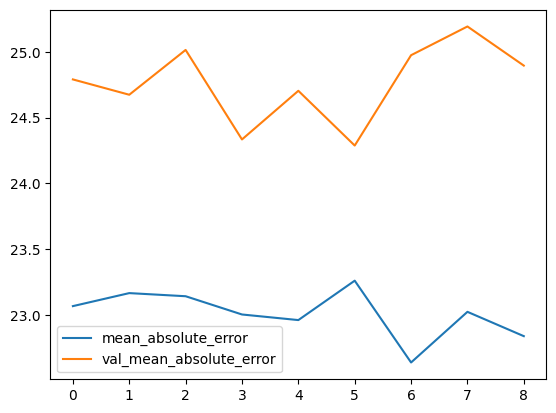

52/52 [==============================] - 10s 196ms/step - loss: 1331.4269 - mean_absolute_error: 22.8389 - val_loss: 1509.0200 - val_mean_absolute_error: 24.8946
Epoch 10/100
52/52 [==============================] - ETA: 0s - loss: 1323.9951 - mean_absolute_error: 22.7399
Epoch 10: val_mean_absolute_error did not improve from 24.28715


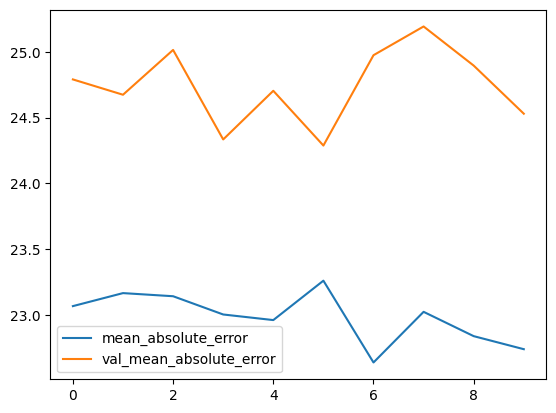

52/52 [==============================] - 10s 195ms/step - loss: 1323.9951 - mean_absolute_error: 22.7399 - val_loss: 1530.7695 - val_mean_absolute_error: 24.5291
Epoch 11/100
52/52 [==============================] - ETA: 0s - loss: 1320.4438 - mean_absolute_error: 22.8166
Epoch 11: val_mean_absolute_error did not improve from 24.28715


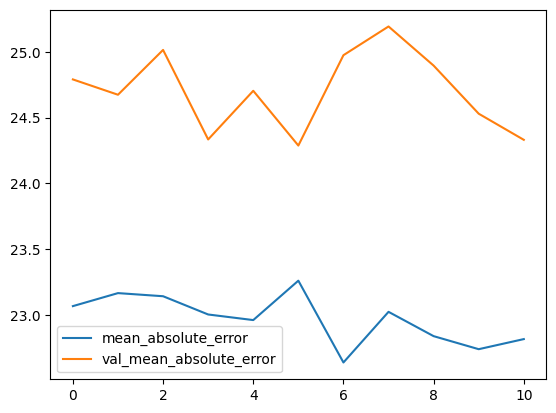

52/52 [==============================] - 10s 198ms/step - loss: 1320.4438 - mean_absolute_error: 22.8166 - val_loss: 1525.5447 - val_mean_absolute_error: 24.3306
Epoch 12/100
52/52 [==============================] - ETA: 0s - loss: 1304.9612 - mean_absolute_error: 22.8241
Epoch 12: val_mean_absolute_error improved from 24.28715 to 24.18198, saving model to temp-from-pre.keras


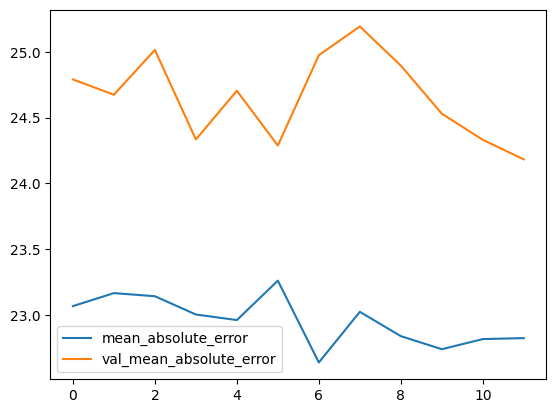

52/52 [==============================] - 11s 211ms/step - loss: 1304.9612 - mean_absolute_error: 22.8241 - val_loss: 1536.8500 - val_mean_absolute_error: 24.1820
Epoch 13/100
52/52 [==============================] - ETA: 0s - loss: 1283.0710 - mean_absolute_error: 22.5306
Epoch 13: val_mean_absolute_error improved from 24.18198 to 23.97932, saving model to temp-from-pre.keras


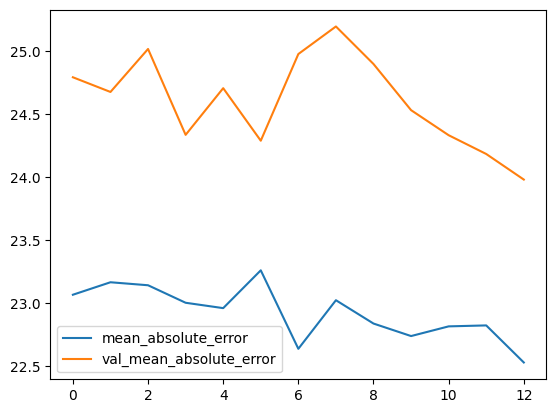

52/52 [==============================] - 11s 212ms/step - loss: 1283.0710 - mean_absolute_error: 22.5306 - val_loss: 1542.3608 - val_mean_absolute_error: 23.9793
Epoch 14/100
52/52 [==============================] - ETA: 0s - loss: 1273.1748 - mean_absolute_error: 22.4314
Epoch 14: val_mean_absolute_error improved from 23.97932 to 23.83890, saving model to temp-from-pre.keras


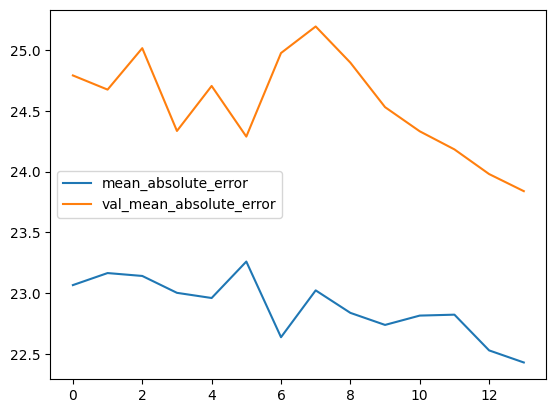

52/52 [==============================] - 11s 213ms/step - loss: 1273.1748 - mean_absolute_error: 22.4314 - val_loss: 1521.9191 - val_mean_absolute_error: 23.8389
Epoch 15/100
52/52 [==============================] - ETA: 0s - loss: 1256.4656 - mean_absolute_error: 22.2390
Epoch 15: val_mean_absolute_error improved from 23.83890 to 23.50726, saving model to temp-from-pre.keras


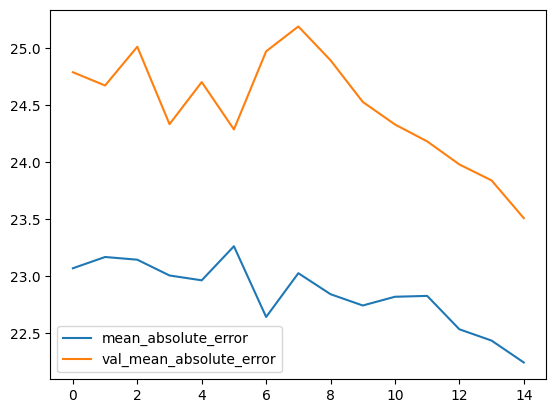

52/52 [==============================] - 11s 213ms/step - loss: 1256.4656 - mean_absolute_error: 22.2390 - val_loss: 1578.2786 - val_mean_absolute_error: 23.5073
Epoch 16/100
52/52 [==============================] - ETA: 0s - loss: 1227.5872 - mean_absolute_error: 21.9797
Epoch 16: val_mean_absolute_error did not improve from 23.50726


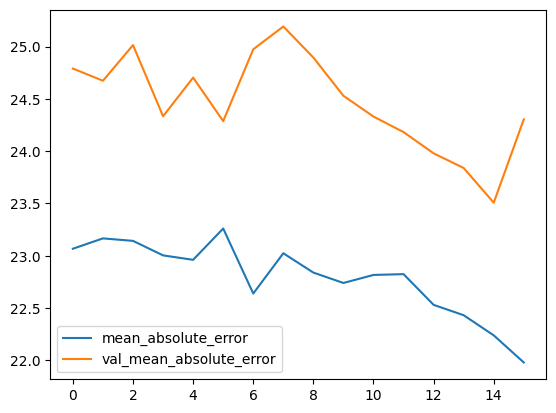

52/52 [==============================] - 10s 195ms/step - loss: 1227.5872 - mean_absolute_error: 21.9797 - val_loss: 1403.8722 - val_mean_absolute_error: 24.3042
Epoch 17/100
52/52 [==============================] - ETA: 0s - loss: 1203.1140 - mean_absolute_error: 21.6056
Epoch 17: val_mean_absolute_error improved from 23.50726 to 23.40245, saving model to temp-from-pre.keras


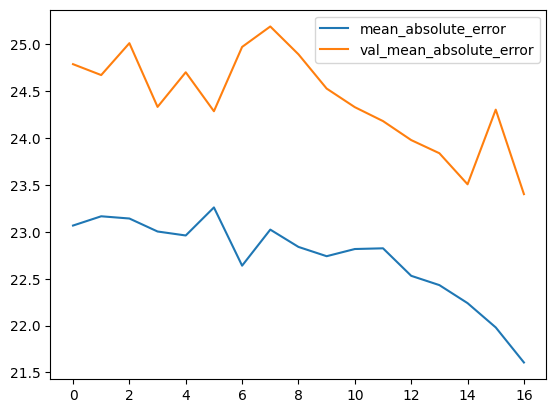

52/52 [==============================] - 11s 213ms/step - loss: 1203.1140 - mean_absolute_error: 21.6056 - val_loss: 1379.6340 - val_mean_absolute_error: 23.4024
Epoch 18/100
52/52 [==============================] - ETA: 0s - loss: 1181.2217 - mean_absolute_error: 21.3045
Epoch 18: val_mean_absolute_error improved from 23.40245 to 22.33853, saving model to temp-from-pre.keras


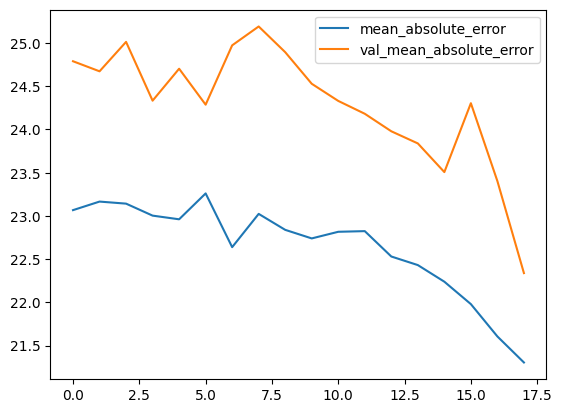

52/52 [==============================] - 11s 219ms/step - loss: 1181.2217 - mean_absolute_error: 21.3045 - val_loss: 1431.5723 - val_mean_absolute_error: 22.3385
Epoch 19/100
52/52 [==============================] - ETA: 0s - loss: 1162.8353 - mean_absolute_error: 20.9692
Epoch 19: val_mean_absolute_error improved from 22.33853 to 22.17640, saving model to temp-from-pre.keras


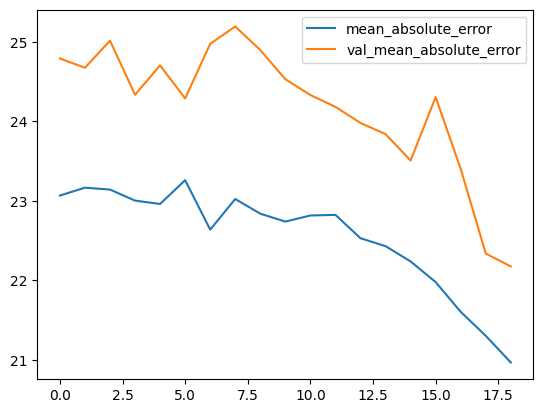

52/52 [==============================] - 12s 221ms/step - loss: 1162.8353 - mean_absolute_error: 20.9692 - val_loss: 1432.2260 - val_mean_absolute_error: 22.1764
Epoch 20/100
52/52 [==============================] - ETA: 0s - loss: 1116.4769 - mean_absolute_error: 20.6254
Epoch 20: val_mean_absolute_error did not improve from 22.17640


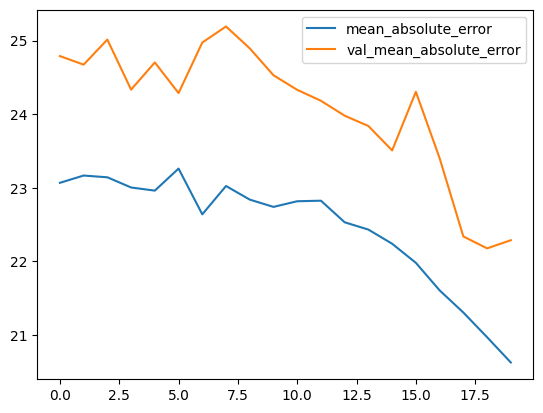

52/52 [==============================] - 10s 197ms/step - loss: 1116.4769 - mean_absolute_error: 20.6254 - val_loss: 1305.8544 - val_mean_absolute_error: 22.2867
Epoch 21/100
52/52 [==============================] - ETA: 0s - loss: 1071.9226 - mean_absolute_error: 20.0888
Epoch 21: val_mean_absolute_error improved from 22.17640 to 21.25029, saving model to temp-from-pre.keras


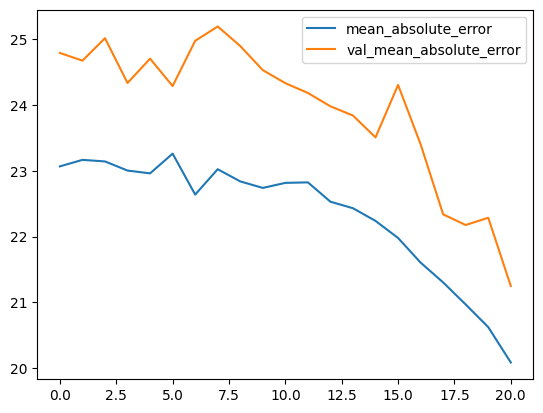

52/52 [==============================] - 11s 213ms/step - loss: 1071.9226 - mean_absolute_error: 20.0888 - val_loss: 1377.8030 - val_mean_absolute_error: 21.2503
Epoch 22/100
52/52 [==============================] - ETA: 0s - loss: 1035.3375 - mean_absolute_error: 19.7052
Epoch 22: val_mean_absolute_error improved from 21.25029 to 20.97073, saving model to temp-from-pre.keras


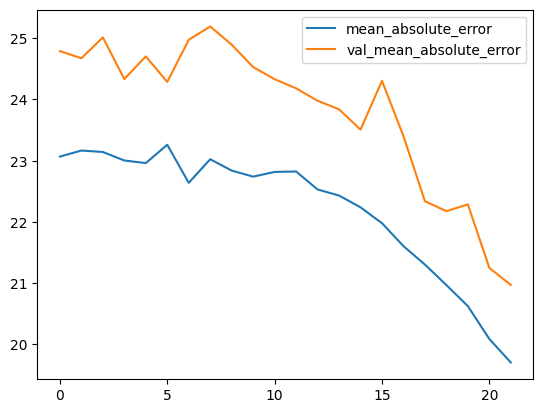

52/52 [==============================] - 11s 214ms/step - loss: 1035.3375 - mean_absolute_error: 19.7052 - val_loss: 1324.6803 - val_mean_absolute_error: 20.9707
Epoch 23/100
52/52 [==============================] - ETA: 0s - loss: 1003.8334 - mean_absolute_error: 19.3133
Epoch 23: val_mean_absolute_error did not improve from 20.97073


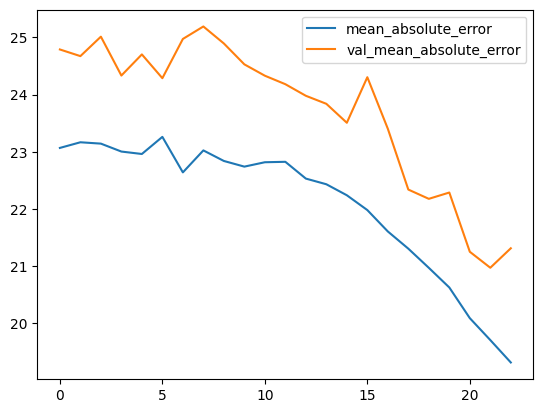

52/52 [==============================] - 10s 196ms/step - loss: 1003.8334 - mean_absolute_error: 19.3133 - val_loss: 1211.8461 - val_mean_absolute_error: 21.3114
Epoch 24/100
52/52 [==============================] - ETA: 0s - loss: 1001.1637 - mean_absolute_error: 19.1732
Epoch 24: val_mean_absolute_error did not improve from 20.97073


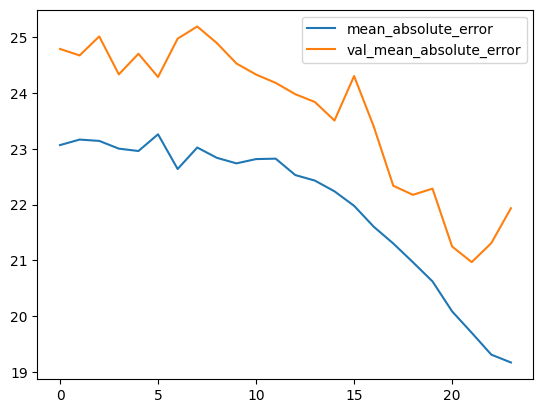

52/52 [==============================] - 10s 195ms/step - loss: 1001.1637 - mean_absolute_error: 19.1732 - val_loss: 1163.3787 - val_mean_absolute_error: 21.9366
Epoch 25/100
52/52 [==============================] - ETA: 0s - loss: 926.7017 - mean_absolute_error: 18.5063
Epoch 25: val_mean_absolute_error did not improve from 20.97073


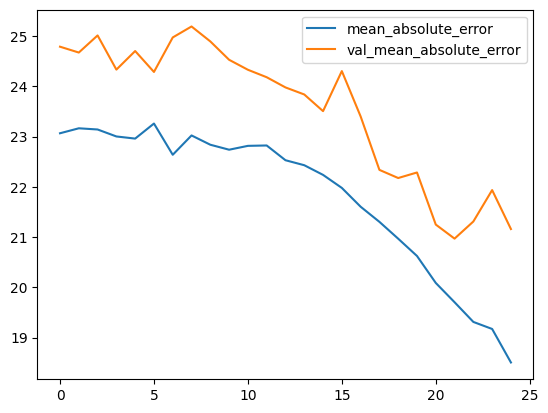

52/52 [==============================] - 10s 195ms/step - loss: 926.7017 - mean_absolute_error: 18.5063 - val_loss: 1128.4033 - val_mean_absolute_error: 21.1613
Epoch 26/100
52/52 [==============================] - ETA: 0s - loss: 930.1475 - mean_absolute_error: 18.7333
Epoch 26: val_mean_absolute_error improved from 20.97073 to 20.46692, saving model to temp-from-pre.keras


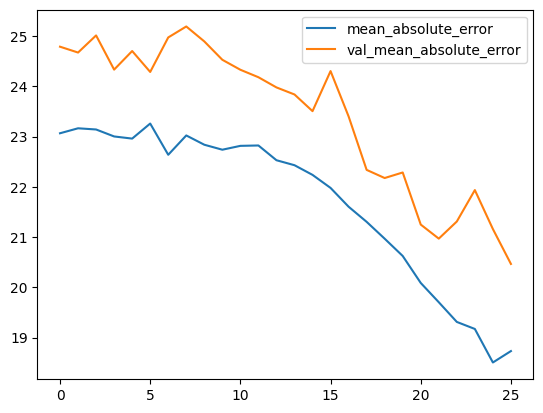

52/52 [==============================] - 11s 214ms/step - loss: 930.1475 - mean_absolute_error: 18.7333 - val_loss: 1117.0415 - val_mean_absolute_error: 20.4669
Epoch 27/100
52/52 [==============================] - ETA: 0s - loss: 948.8166 - mean_absolute_error: 18.8788
Epoch 27: val_mean_absolute_error did not improve from 20.46692


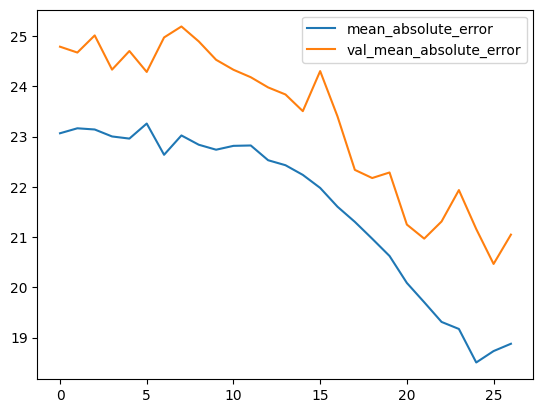

52/52 [==============================] - 10s 196ms/step - loss: 948.8166 - mean_absolute_error: 18.8788 - val_loss: 1087.1189 - val_mean_absolute_error: 21.0501
Epoch 28/100
52/52 [==============================] - ETA: 0s - loss: 935.0435 - mean_absolute_error: 18.8470
Epoch 28: val_mean_absolute_error did not improve from 20.46692


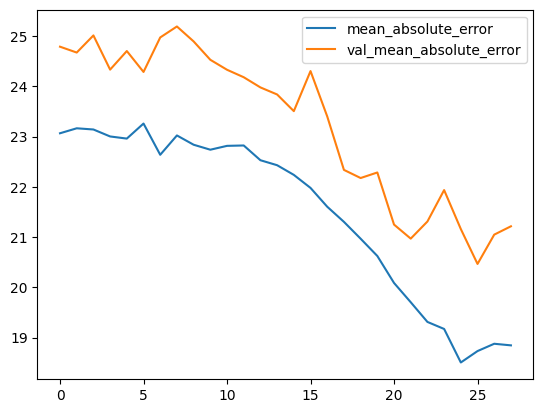

52/52 [==============================] - 10s 195ms/step - loss: 935.0435 - mean_absolute_error: 18.8470 - val_loss: 1073.7473 - val_mean_absolute_error: 21.2160
Epoch 29/100
52/52 [==============================] - ETA: 0s - loss: 893.9970 - mean_absolute_error: 18.3185
Epoch 29: val_mean_absolute_error improved from 20.46692 to 20.11966, saving model to temp-from-pre.keras


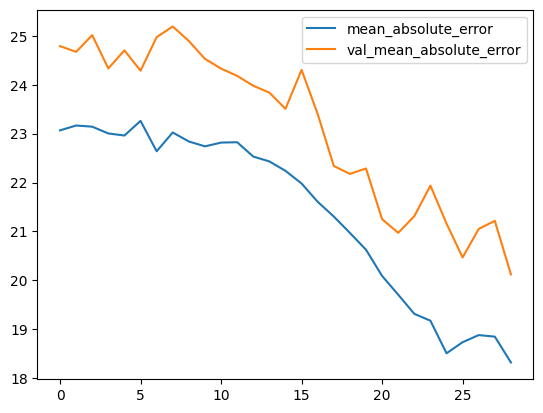

52/52 [==============================] - 11s 212ms/step - loss: 893.9970 - mean_absolute_error: 18.3185 - val_loss: 1058.0448 - val_mean_absolute_error: 20.1197
Epoch 30/100
52/52 [==============================] - ETA: 0s - loss: 838.3872 - mean_absolute_error: 17.8933
Epoch 30: val_mean_absolute_error did not improve from 20.11966


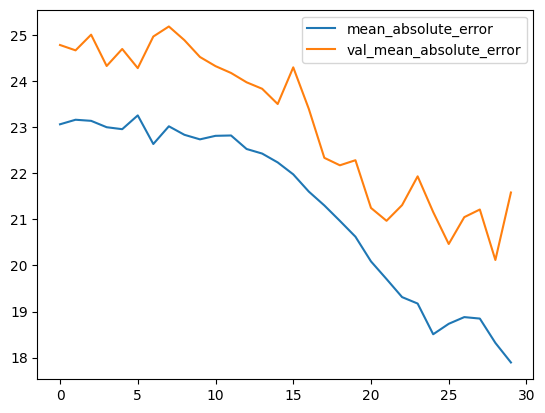

52/52 [==============================] - 10s 197ms/step - loss: 838.3872 - mean_absolute_error: 17.8933 - val_loss: 1061.4430 - val_mean_absolute_error: 21.5853
Epoch 31/100
52/52 [==============================] - ETA: 0s - loss: 861.7083 - mean_absolute_error: 18.1299
Epoch 31: val_mean_absolute_error improved from 20.11966 to 19.67031, saving model to temp-from-pre.keras


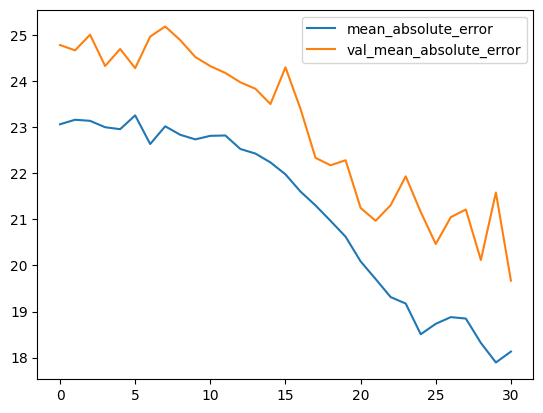

52/52 [==============================] - 11s 219ms/step - loss: 861.7083 - mean_absolute_error: 18.1299 - val_loss: 1032.0886 - val_mean_absolute_error: 19.6703
Epoch 32/100
52/52 [==============================] - ETA: 0s - loss: 860.4637 - mean_absolute_error: 18.1457
Epoch 32: val_mean_absolute_error did not improve from 19.67031


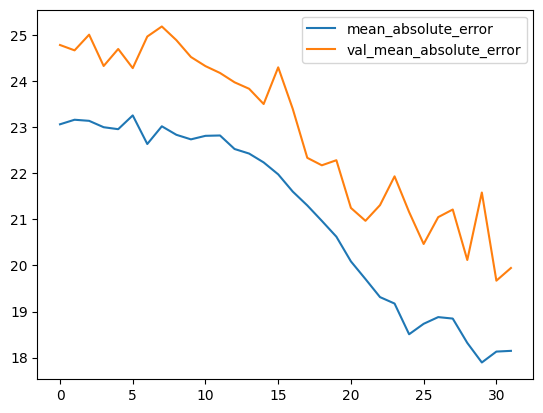

52/52 [==============================] - 10s 196ms/step - loss: 860.4637 - mean_absolute_error: 18.1457 - val_loss: 1013.0138 - val_mean_absolute_error: 19.9458
Epoch 33/100
52/52 [==============================] - ETA: 0s - loss: 831.8439 - mean_absolute_error: 17.9356
Epoch 33: val_mean_absolute_error improved from 19.67031 to 19.62038, saving model to temp-from-pre.keras


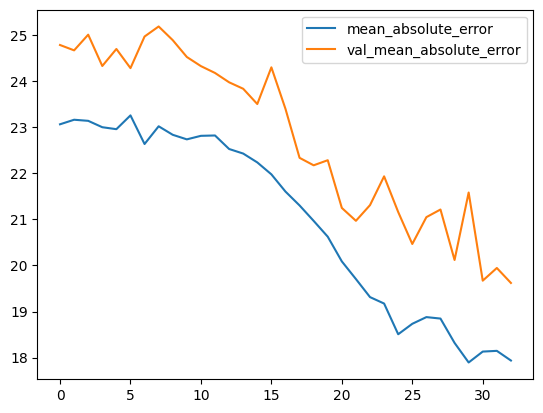

52/52 [==============================] - 11s 217ms/step - loss: 831.8439 - mean_absolute_error: 17.9356 - val_loss: 1135.0769 - val_mean_absolute_error: 19.6204
Epoch 34/100
52/52 [==============================] - ETA: 0s - loss: 815.8082 - mean_absolute_error: 17.7110
Epoch 34: val_mean_absolute_error did not improve from 19.62038


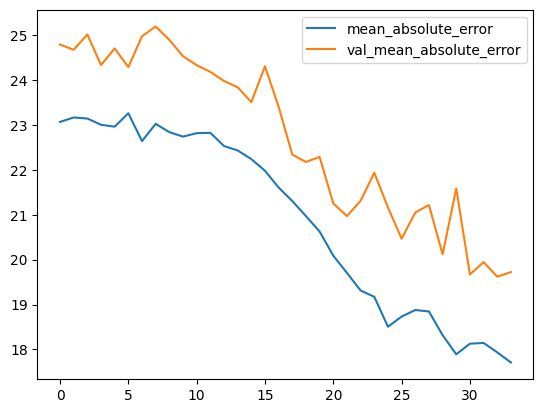

52/52 [==============================] - 10s 195ms/step - loss: 815.8082 - mean_absolute_error: 17.7110 - val_loss: 988.1261 - val_mean_absolute_error: 19.7240
Epoch 35/100
52/52 [==============================] - ETA: 0s - loss: 794.7099 - mean_absolute_error: 17.5471
Epoch 35: val_mean_absolute_error did not improve from 19.62038


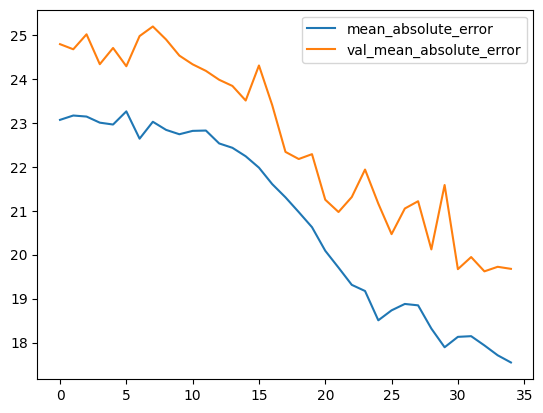

52/52 [==============================] - 10s 195ms/step - loss: 794.7099 - mean_absolute_error: 17.5471 - val_loss: 980.9767 - val_mean_absolute_error: 19.6775
Epoch 36/100
52/52 [==============================] - ETA: 0s - loss: 817.5857 - mean_absolute_error: 17.8013
Epoch 36: val_mean_absolute_error did not improve from 19.62038


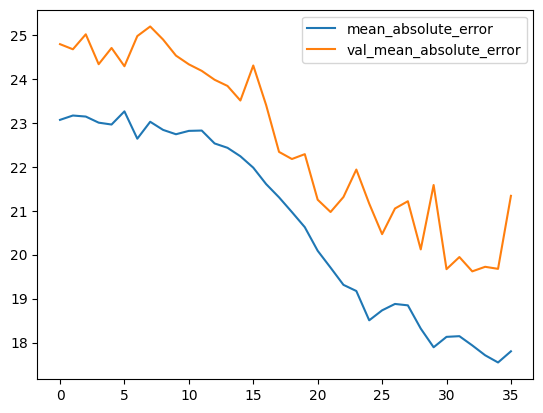

52/52 [==============================] - 10s 195ms/step - loss: 817.5857 - mean_absolute_error: 17.8013 - val_loss: 1019.5607 - val_mean_absolute_error: 21.3384
Epoch 37/100
52/52 [==============================] - ETA: 0s - loss: 790.2084 - mean_absolute_error: 17.4650
Epoch 37: val_mean_absolute_error improved from 19.62038 to 19.22899, saving model to temp-from-pre.keras


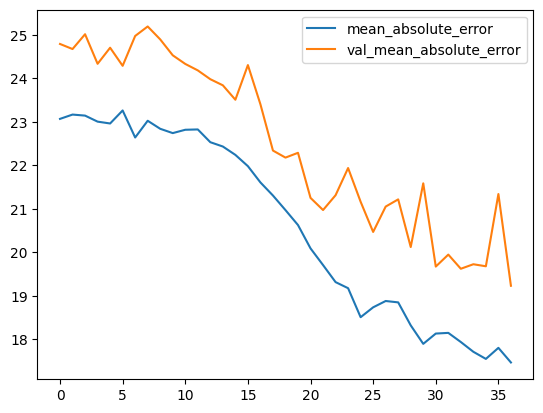

52/52 [==============================] - 11s 213ms/step - loss: 790.2084 - mean_absolute_error: 17.4650 - val_loss: 983.0275 - val_mean_absolute_error: 19.2290
Epoch 38/100
52/52 [==============================] - ETA: 0s - loss: 766.8874 - mean_absolute_error: 17.3166
Epoch 38: val_mean_absolute_error did not improve from 19.22899


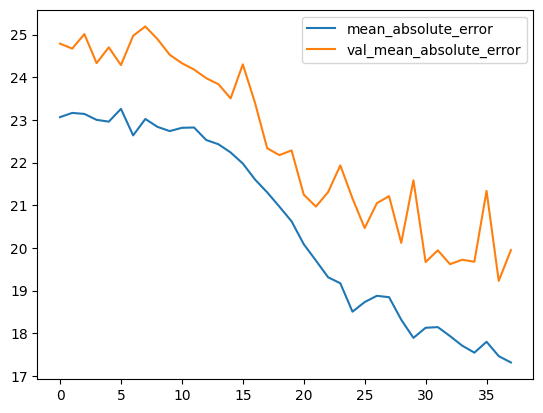

52/52 [==============================] - 10s 195ms/step - loss: 766.8874 - mean_absolute_error: 17.3166 - val_loss: 964.0253 - val_mean_absolute_error: 19.9517
Epoch 39/100
52/52 [==============================] - ETA: 0s - loss: 801.9704 - mean_absolute_error: 17.5387
Epoch 39: val_mean_absolute_error did not improve from 19.22899


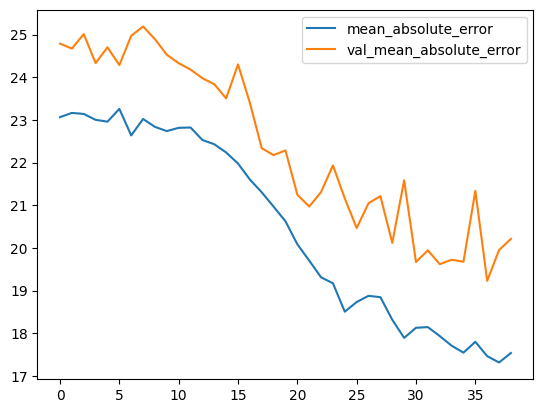

52/52 [==============================] - 10s 195ms/step - loss: 801.9704 - mean_absolute_error: 17.5387 - val_loss: 967.1540 - val_mean_absolute_error: 20.2138
Epoch 40/100
52/52 [==============================] - ETA: 0s - loss: 789.4680 - mean_absolute_error: 17.3462
Epoch 40: val_mean_absolute_error did not improve from 19.22899


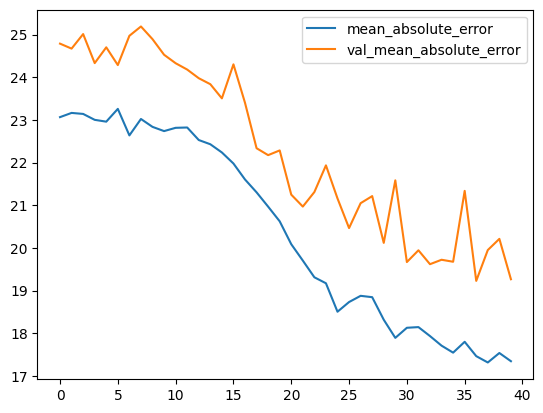

52/52 [==============================] - 10s 196ms/step - loss: 789.4680 - mean_absolute_error: 17.3462 - val_loss: 960.2933 - val_mean_absolute_error: 19.2675
Epoch 41/100
52/52 [==============================] - ETA: 0s - loss: 815.3016 - mean_absolute_error: 17.7711
Epoch 41: val_mean_absolute_error improved from 19.22899 to 19.04449, saving model to temp-from-pre.keras


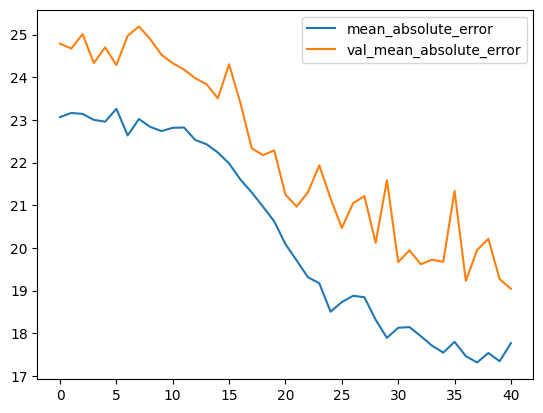

52/52 [==============================] - 11s 213ms/step - loss: 815.3016 - mean_absolute_error: 17.7711 - val_loss: 976.3506 - val_mean_absolute_error: 19.0445
Epoch 42/100
52/52 [==============================] - ETA: 0s - loss: 785.0021 - mean_absolute_error: 17.4774
Epoch 42: val_mean_absolute_error improved from 19.04449 to 18.99703, saving model to temp-from-pre.keras


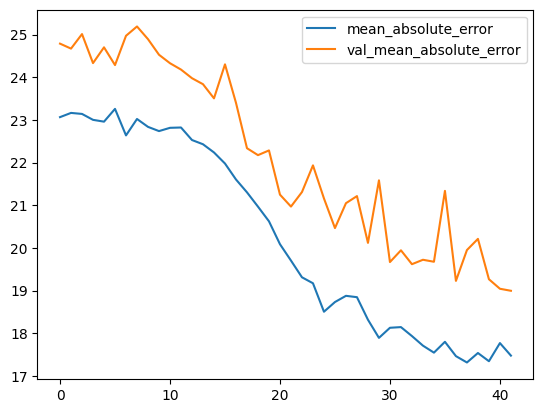

52/52 [==============================] - 11s 212ms/step - loss: 785.0021 - mean_absolute_error: 17.4774 - val_loss: 976.1598 - val_mean_absolute_error: 18.9970
Epoch 43/100
52/52 [==============================] - ETA: 0s - loss: 791.8448 - mean_absolute_error: 17.4812
Epoch 43: val_mean_absolute_error did not improve from 18.99703


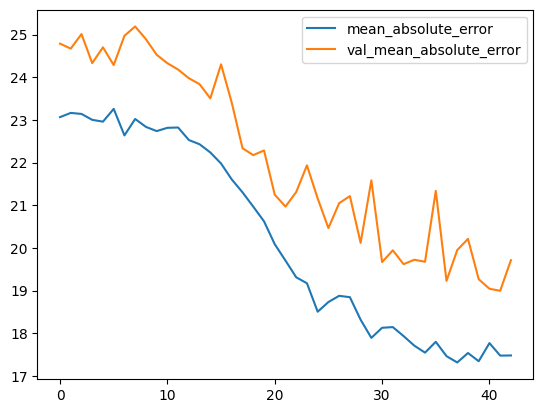

52/52 [==============================] - 10s 196ms/step - loss: 791.8448 - mean_absolute_error: 17.4812 - val_loss: 947.1589 - val_mean_absolute_error: 19.7146
Epoch 44/100
52/52 [==============================] - ETA: 0s - loss: 826.0447 - mean_absolute_error: 17.7544
Epoch 44: val_mean_absolute_error did not improve from 18.99703


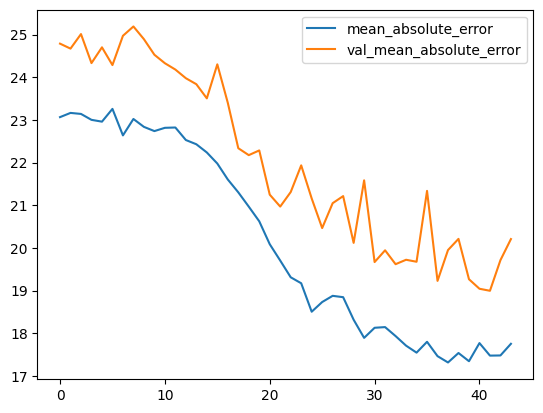

52/52 [==============================] - 10s 195ms/step - loss: 826.0447 - mean_absolute_error: 17.7544 - val_loss: 960.8245 - val_mean_absolute_error: 20.2090
Epoch 45/100
52/52 [==============================] - ETA: 0s - loss: 820.7410 - mean_absolute_error: 17.9719
Epoch 45: val_mean_absolute_error did not improve from 18.99703


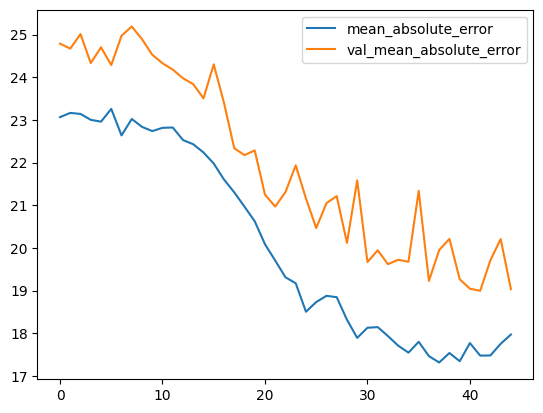

52/52 [==============================] - 10s 195ms/step - loss: 820.7410 - mean_absolute_error: 17.9719 - val_loss: 1050.6626 - val_mean_absolute_error: 19.0342
Epoch 46/100
52/52 [==============================] - ETA: 0s - loss: 751.6406 - mean_absolute_error: 17.0195
Epoch 46: val_mean_absolute_error did not improve from 18.99703


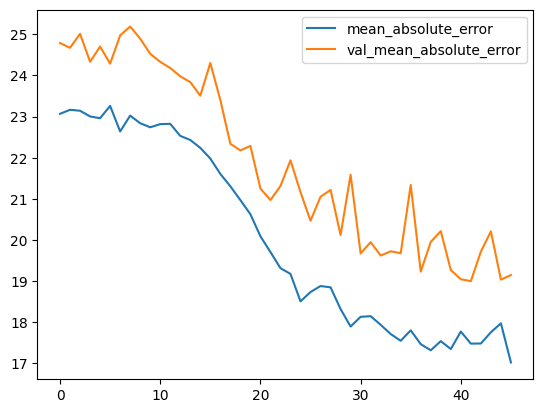

52/52 [==============================] - 10s 194ms/step - loss: 751.6406 - mean_absolute_error: 17.0195 - val_loss: 945.2304 - val_mean_absolute_error: 19.1462
Epoch 47/100
52/52 [==============================] - ETA: 0s - loss: 787.0887 - mean_absolute_error: 17.3632
Epoch 47: val_mean_absolute_error did not improve from 18.99703


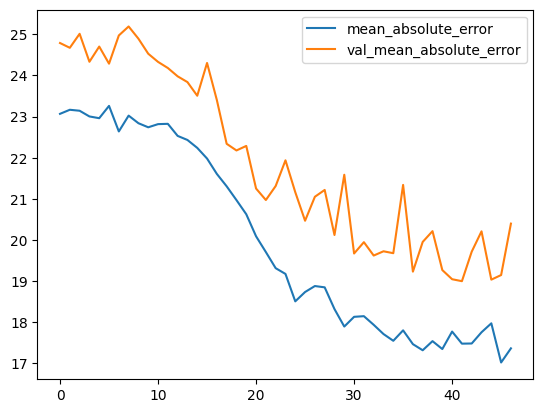

52/52 [==============================] - 10s 195ms/step - loss: 787.0887 - mean_absolute_error: 17.3632 - val_loss: 958.9315 - val_mean_absolute_error: 20.3970
Epoch 48/100
52/52 [==============================] - ETA: 0s - loss: 758.7224 - mean_absolute_error: 17.2986
Epoch 48: val_mean_absolute_error did not improve from 18.99703


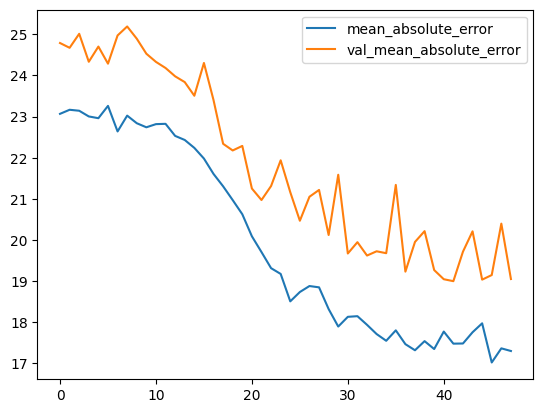

52/52 [==============================] - 10s 194ms/step - loss: 758.7224 - mean_absolute_error: 17.2986 - val_loss: 1043.3827 - val_mean_absolute_error: 19.0494
Epoch 49/100
52/52 [==============================] - ETA: 0s - loss: 782.6487 - mean_absolute_error: 17.4378
Epoch 49: val_mean_absolute_error improved from 18.99703 to 18.85379, saving model to temp-from-pre.keras


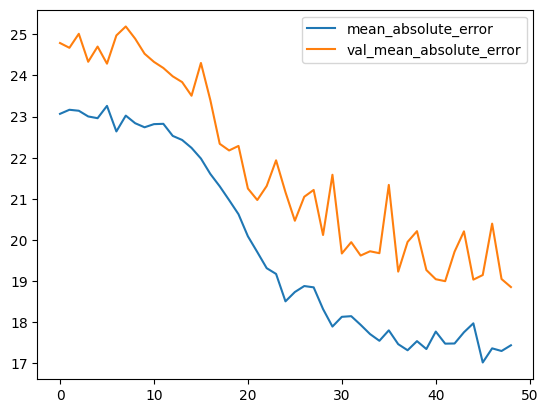

52/52 [==============================] - 11s 213ms/step - loss: 782.6487 - mean_absolute_error: 17.4378 - val_loss: 964.2781 - val_mean_absolute_error: 18.8538
Epoch 50/100
52/52 [==============================] - ETA: 0s - loss: 767.5980 - mean_absolute_error: 17.1840
Epoch 50: val_mean_absolute_error did not improve from 18.85379


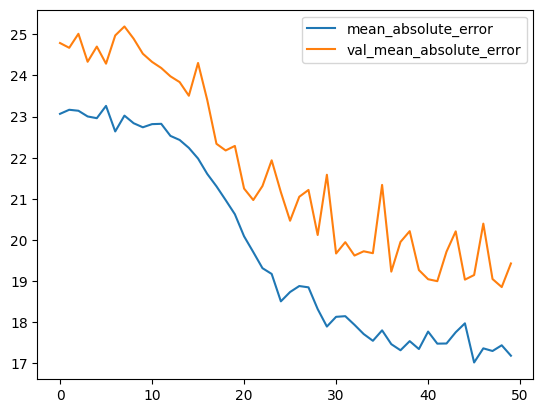

52/52 [==============================] - 10s 197ms/step - loss: 767.5980 - mean_absolute_error: 17.1840 - val_loss: 933.1296 - val_mean_absolute_error: 19.4277
Epoch 51/100
52/52 [==============================] - ETA: 0s - loss: 751.8260 - mean_absolute_error: 17.1977
Epoch 51: val_mean_absolute_error did not improve from 18.85379


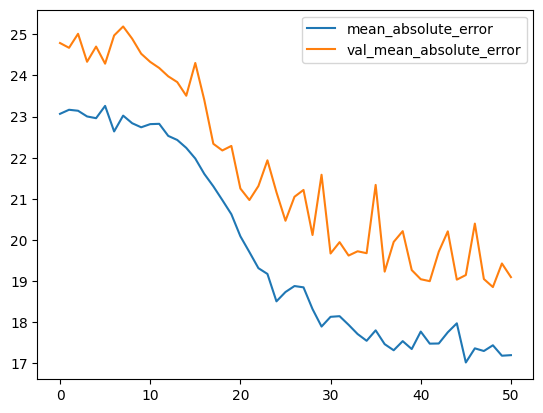

52/52 [==============================] - 10s 200ms/step - loss: 751.8260 - mean_absolute_error: 17.1977 - val_loss: 928.6543 - val_mean_absolute_error: 19.0956
Epoch 52/100
52/52 [==============================] - ETA: 0s - loss: 762.4875 - mean_absolute_error: 17.2723
Epoch 52: val_mean_absolute_error did not improve from 18.85379


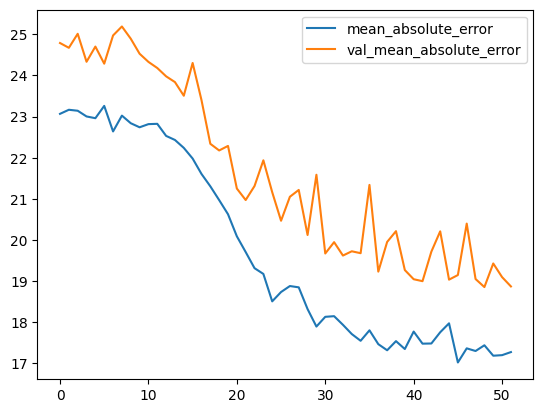

52/52 [==============================] - 11s 206ms/step - loss: 762.4875 - mean_absolute_error: 17.2723 - val_loss: 936.8577 - val_mean_absolute_error: 18.8691
Epoch 53/100
52/52 [==============================] - ETA: 0s - loss: 736.1203 - mean_absolute_error: 16.9433
Epoch 53: val_mean_absolute_error did not improve from 18.85379


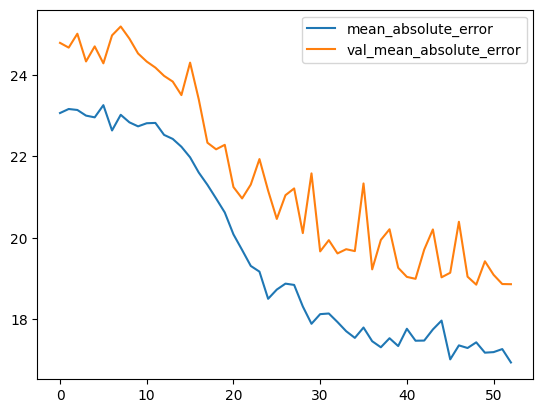

52/52 [==============================] - 10s 197ms/step - loss: 736.1203 - mean_absolute_error: 16.9433 - val_loss: 935.5143 - val_mean_absolute_error: 18.8652
Epoch 54/100
52/52 [==============================] - ETA: 0s - loss: 761.7623 - mean_absolute_error: 17.2459
Epoch 54: val_mean_absolute_error did not improve from 18.85379


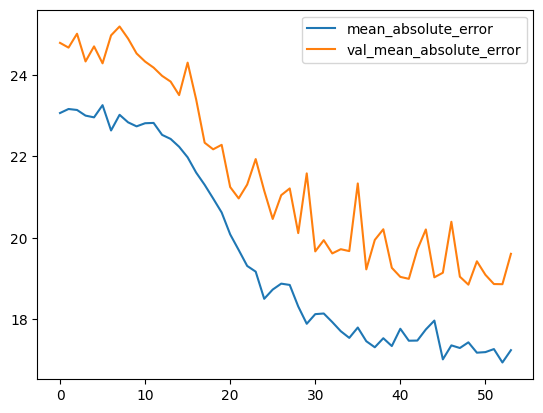

52/52 [==============================] - 10s 198ms/step - loss: 761.7623 - mean_absolute_error: 17.2459 - val_loss: 924.0067 - val_mean_absolute_error: 19.6109
Epoch 55/100
52/52 [==============================] - ETA: 0s - loss: 741.4520 - mean_absolute_error: 17.0497
Epoch 55: val_mean_absolute_error improved from 18.85379 to 18.76172, saving model to temp-from-pre.keras


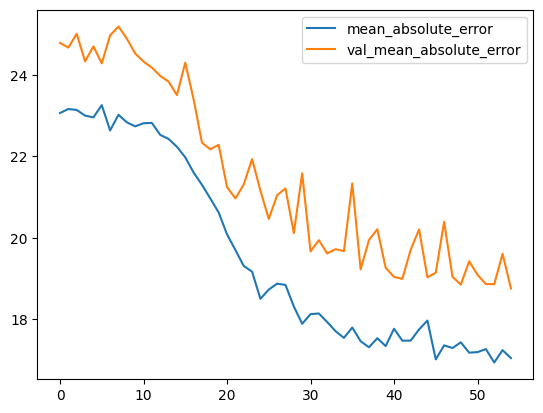

52/52 [==============================] - 11s 212ms/step - loss: 741.4520 - mean_absolute_error: 17.0497 - val_loss: 980.8087 - val_mean_absolute_error: 18.7617
Epoch 56/100
52/52 [==============================] - ETA: 0s - loss: 728.3873 - mean_absolute_error: 16.8971
Epoch 56: val_mean_absolute_error did not improve from 18.76172


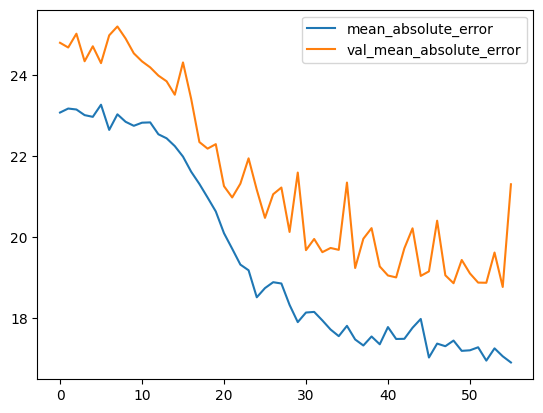

52/52 [==============================] - 10s 196ms/step - loss: 728.3873 - mean_absolute_error: 16.8971 - val_loss: 1003.8161 - val_mean_absolute_error: 21.2963
Epoch 57/100
52/52 [==============================] - ETA: 0s - loss: 782.3909 - mean_absolute_error: 17.3361
Epoch 57: val_mean_absolute_error did not improve from 18.76172


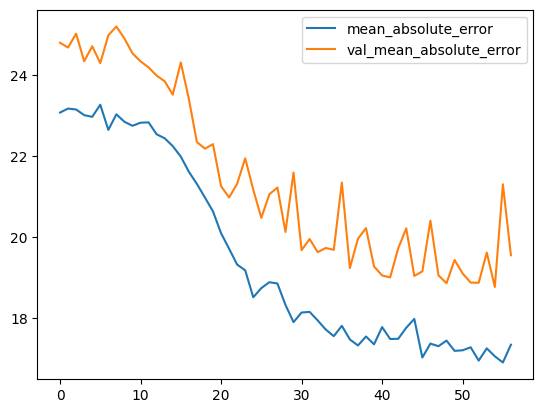

52/52 [==============================] - 11s 200ms/step - loss: 782.3909 - mean_absolute_error: 17.3361 - val_loss: 916.8295 - val_mean_absolute_error: 19.5439
Epoch 58/100
52/52 [==============================] - ETA: 0s - loss: 746.9694 - mean_absolute_error: 17.0914
Epoch 58: val_mean_absolute_error did not improve from 18.76172


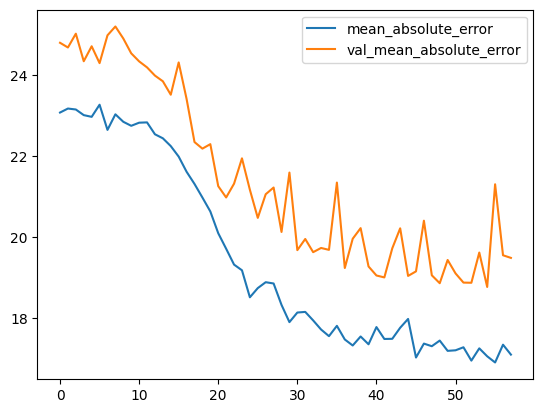

52/52 [==============================] - 10s 195ms/step - loss: 746.9694 - mean_absolute_error: 17.0914 - val_loss: 914.7592 - val_mean_absolute_error: 19.4790
Epoch 59/100
52/52 [==============================] - ETA: 0s - loss: 760.8448 - mean_absolute_error: 17.2707
Epoch 59: val_mean_absolute_error improved from 18.76172 to 18.70450, saving model to temp-from-pre.keras


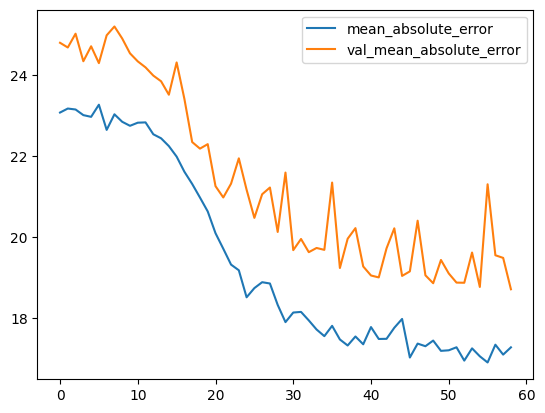

52/52 [==============================] - 11s 212ms/step - loss: 760.8448 - mean_absolute_error: 17.2707 - val_loss: 949.1629 - val_mean_absolute_error: 18.7045
Epoch 60/100
52/52 [==============================] - ETA: 0s - loss: 782.1821 - mean_absolute_error: 17.3580
Epoch 60: val_mean_absolute_error did not improve from 18.70450


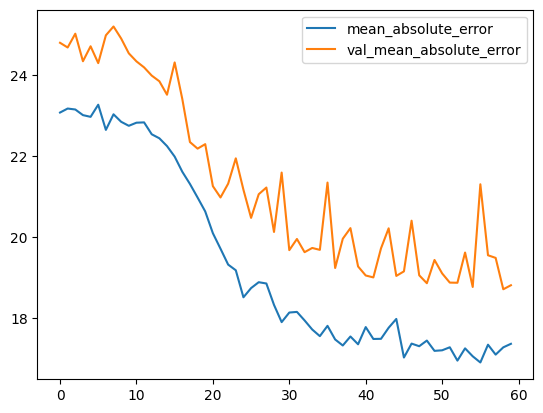

52/52 [==============================] - 10s 196ms/step - loss: 782.1821 - mean_absolute_error: 17.3580 - val_loss: 928.9714 - val_mean_absolute_error: 18.8039
Epoch 61/100
52/52 [==============================] - ETA: 0s - loss: 710.1203 - mean_absolute_error: 16.8397
Epoch 61: val_mean_absolute_error did not improve from 18.70450


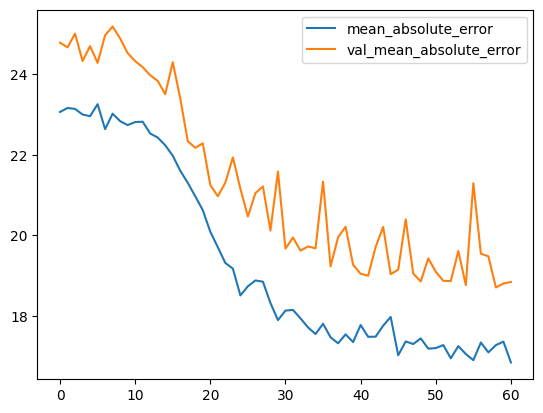

52/52 [==============================] - 10s 195ms/step - loss: 710.1203 - mean_absolute_error: 16.8397 - val_loss: 907.8275 - val_mean_absolute_error: 18.8400
Epoch 62/100
52/52 [==============================] - ETA: 0s - loss: 721.4125 - mean_absolute_error: 16.7635
Epoch 62: val_mean_absolute_error did not improve from 18.70450


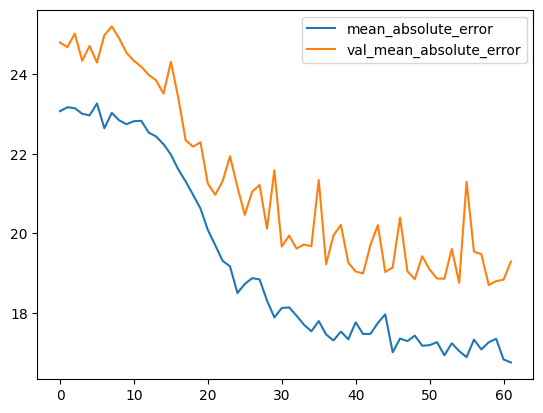

52/52 [==============================] - 10s 195ms/step - loss: 721.4125 - mean_absolute_error: 16.7635 - val_loss: 905.9761 - val_mean_absolute_error: 19.2959
Epoch 63/100
52/52 [==============================] - ETA: 0s - loss: 735.2039 - mean_absolute_error: 16.9872
Epoch 63: val_mean_absolute_error did not improve from 18.70450


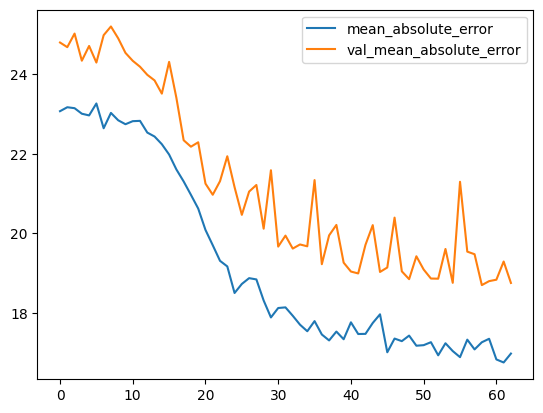

52/52 [==============================] - 10s 195ms/step - loss: 735.2039 - mean_absolute_error: 16.9872 - val_loss: 905.9886 - val_mean_absolute_error: 18.7582
Epoch 64/100
52/52 [==============================] - ETA: 0s - loss: 738.7069 - mean_absolute_error: 16.8893
Epoch 64: val_mean_absolute_error improved from 18.70450 to 18.60965, saving model to temp-from-pre.keras


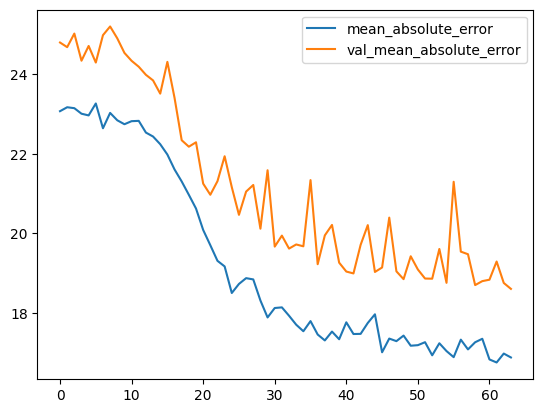

52/52 [==============================] - 11s 213ms/step - loss: 738.7069 - mean_absolute_error: 16.8893 - val_loss: 926.9232 - val_mean_absolute_error: 18.6096
Epoch 65/100
52/52 [==============================] - ETA: 0s - loss: 726.6509 - mean_absolute_error: 16.8854
Epoch 65: val_mean_absolute_error did not improve from 18.60965


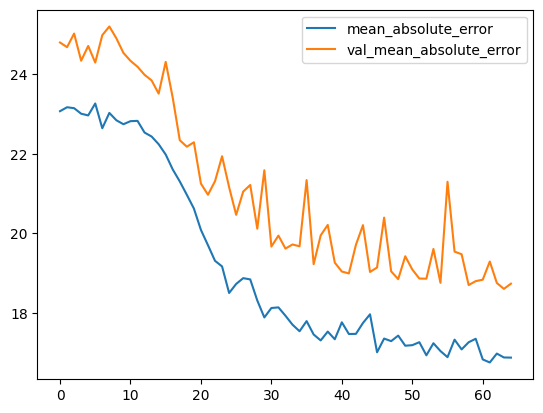

52/52 [==============================] - 10s 196ms/step - loss: 726.6509 - mean_absolute_error: 16.8854 - val_loss: 902.3498 - val_mean_absolute_error: 18.7400
Epoch 66/100
52/52 [==============================] - ETA: 0s - loss: 729.3248 - mean_absolute_error: 16.8725
Epoch 66: val_mean_absolute_error did not improve from 18.60965


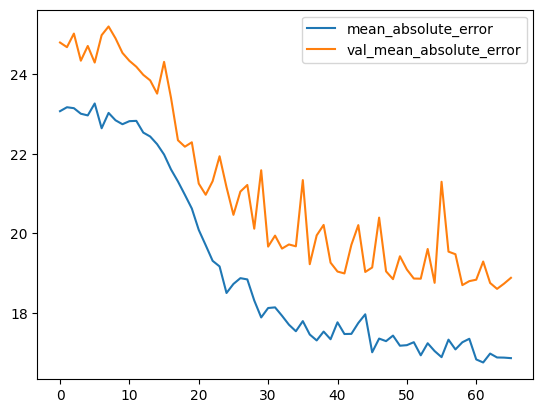

52/52 [==============================] - 10s 195ms/step - loss: 729.3248 - mean_absolute_error: 16.8725 - val_loss: 894.4676 - val_mean_absolute_error: 18.8871
Epoch 67/100
52/52 [==============================] - ETA: 0s - loss: 733.6309 - mean_absolute_error: 16.9077
Epoch 67: val_mean_absolute_error did not improve from 18.60965


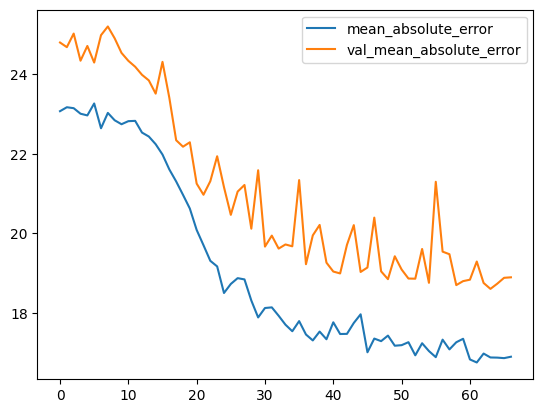

52/52 [==============================] - 10s 195ms/step - loss: 733.6309 - mean_absolute_error: 16.9077 - val_loss: 894.1862 - val_mean_absolute_error: 18.8998
Epoch 68/100
52/52 [==============================] - ETA: 0s - loss: 734.9874 - mean_absolute_error: 16.8377
Epoch 68: val_mean_absolute_error did not improve from 18.60965


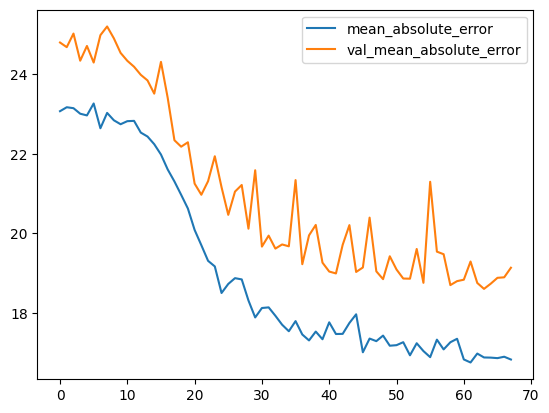

52/52 [==============================] - 10s 195ms/step - loss: 734.9874 - mean_absolute_error: 16.8377 - val_loss: 1048.4952 - val_mean_absolute_error: 19.1403
Epoch 69/100
52/52 [==============================] - ETA: 0s - loss: 716.4055 - mean_absolute_error: 16.7429
Epoch 69: val_mean_absolute_error improved from 18.60965 to 18.53248, saving model to temp-from-pre.keras


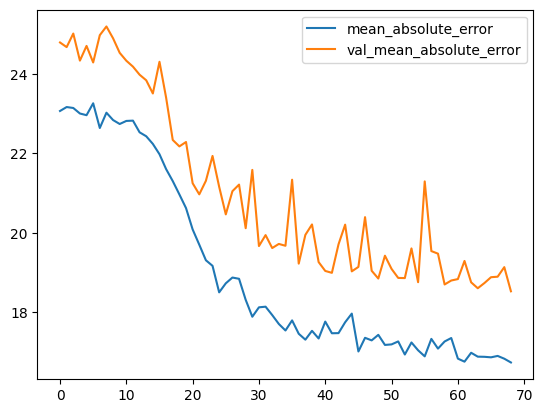

52/52 [==============================] - 11s 212ms/step - loss: 716.4055 - mean_absolute_error: 16.7429 - val_loss: 908.8748 - val_mean_absolute_error: 18.5325
Epoch 70/100
52/52 [==============================] - ETA: 0s - loss: 722.0118 - mean_absolute_error: 16.8270
Epoch 70: val_mean_absolute_error did not improve from 18.53248


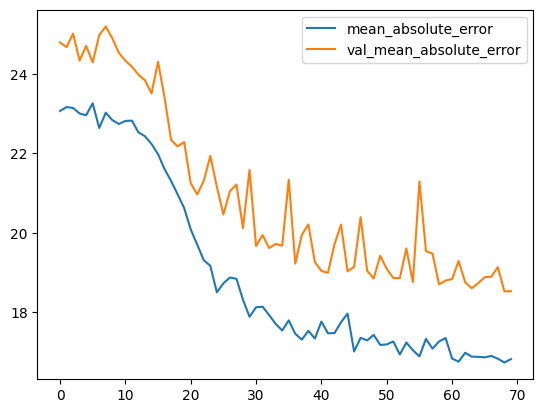

52/52 [==============================] - 10s 197ms/step - loss: 722.0118 - mean_absolute_error: 16.8270 - val_loss: 902.2670 - val_mean_absolute_error: 18.5340
Epoch 71/100
52/52 [==============================] - ETA: 0s - loss: 719.0225 - mean_absolute_error: 16.8499
Epoch 71: val_mean_absolute_error improved from 18.53248 to 18.44598, saving model to temp-from-pre.keras


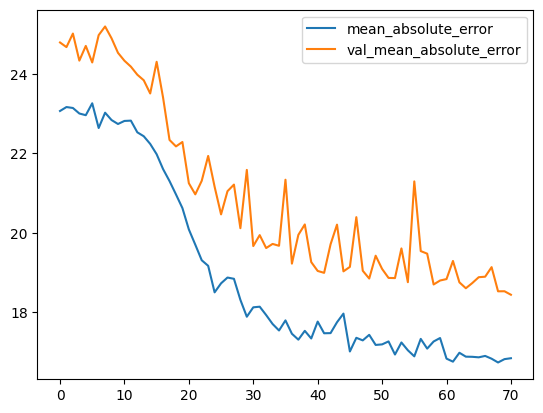

52/52 [==============================] - 11s 212ms/step - loss: 719.0225 - mean_absolute_error: 16.8499 - val_loss: 920.4442 - val_mean_absolute_error: 18.4460
Epoch 72/100
52/52 [==============================] - ETA: 0s - loss: 729.2392 - mean_absolute_error: 16.7311
Epoch 72: val_mean_absolute_error did not improve from 18.44598


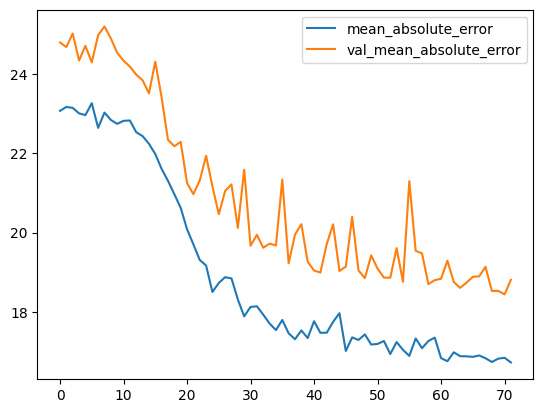

52/52 [==============================] - 10s 196ms/step - loss: 729.2392 - mean_absolute_error: 16.7311 - val_loss: 882.5642 - val_mean_absolute_error: 18.8137
Epoch 73/100
52/52 [==============================] - ETA: 0s - loss: 727.8228 - mean_absolute_error: 16.8840
Epoch 73: val_mean_absolute_error did not improve from 18.44598


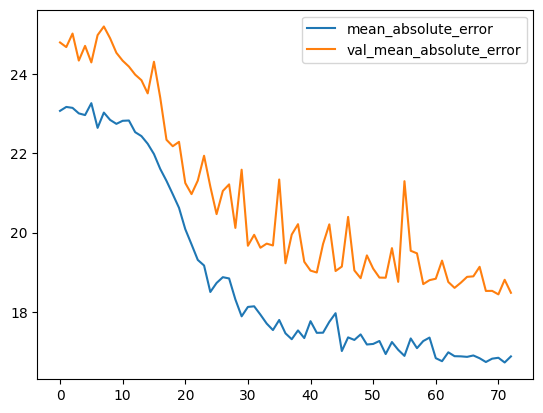

52/52 [==============================] - 11s 206ms/step - loss: 727.8228 - mean_absolute_error: 16.8840 - val_loss: 908.9725 - val_mean_absolute_error: 18.4858
Epoch 74/100
52/52 [==============================] - ETA: 0s - loss: 717.2766 - mean_absolute_error: 16.7728
Epoch 74: val_mean_absolute_error did not improve from 18.44598


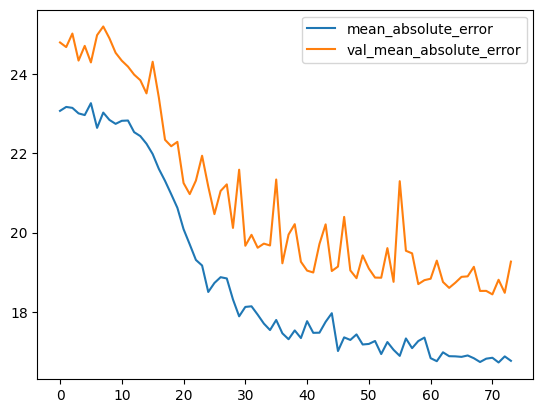

52/52 [==============================] - 10s 198ms/step - loss: 717.2766 - mean_absolute_error: 16.7728 - val_loss: 888.0460 - val_mean_absolute_error: 19.2708
Epoch 75/100
52/52 [==============================] - ETA: 0s - loss: 718.4959 - mean_absolute_error: 16.7111
Epoch 75: val_mean_absolute_error did not improve from 18.44598


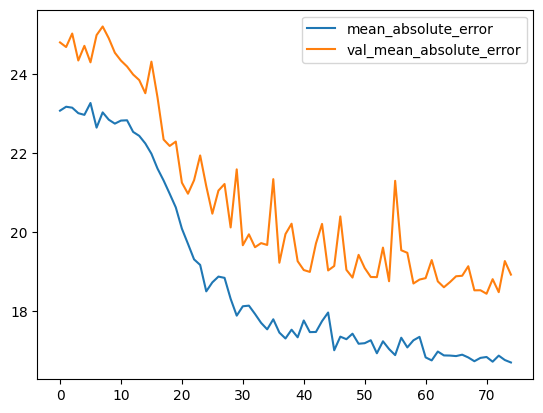

52/52 [==============================] - 11s 200ms/step - loss: 718.4959 - mean_absolute_error: 16.7111 - val_loss: 880.7202 - val_mean_absolute_error: 18.9290
Epoch 76/100
52/52 [==============================] - ETA: 0s - loss: 697.3528 - mean_absolute_error: 16.4547
Epoch 76: val_mean_absolute_error did not improve from 18.44598


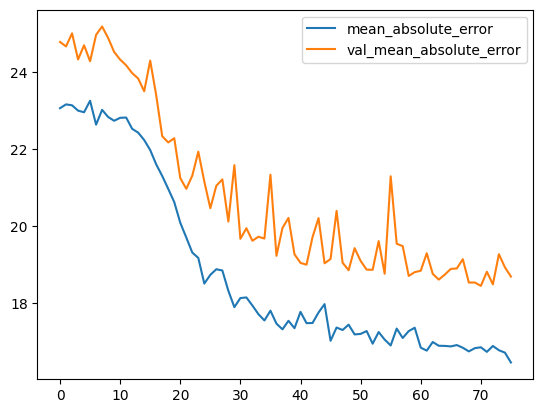

52/52 [==============================] - 10s 195ms/step - loss: 697.3528 - mean_absolute_error: 16.4547 - val_loss: 878.0511 - val_mean_absolute_error: 18.6890
Epoch 77/100
52/52 [==============================] - ETA: 0s - loss: 711.5835 - mean_absolute_error: 16.6019
Epoch 77: val_mean_absolute_error did not improve from 18.44598


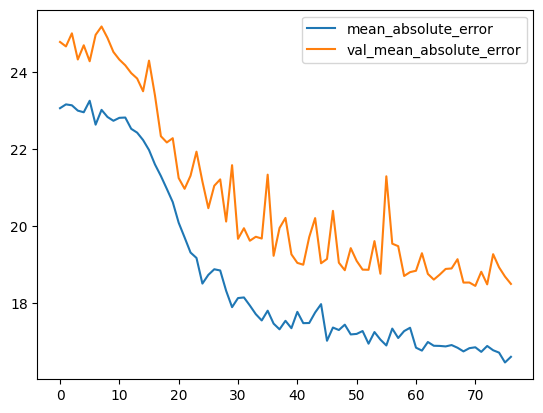

52/52 [==============================] - 10s 195ms/step - loss: 711.5835 - mean_absolute_error: 16.6019 - val_loss: 983.0859 - val_mean_absolute_error: 18.4975
Epoch 78/100
52/52 [==============================] - ETA: 0s - loss: 699.4155 - mean_absolute_error: 16.5332
Epoch 78: val_mean_absolute_error did not improve from 18.44598


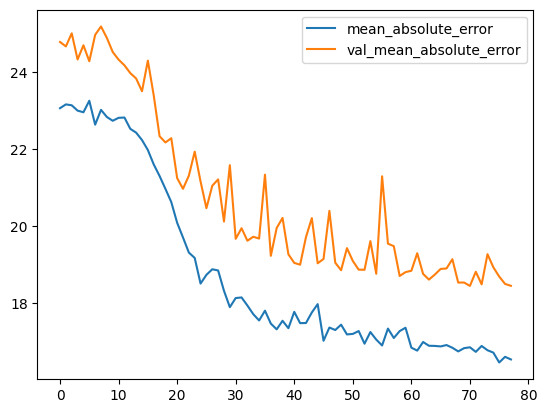

52/52 [==============================] - 10s 195ms/step - loss: 699.4155 - mean_absolute_error: 16.5332 - val_loss: 889.8515 - val_mean_absolute_error: 18.4482
Epoch 79/100
52/52 [==============================] - ETA: 0s - loss: 710.5801 - mean_absolute_error: 16.5555
Epoch 79: val_mean_absolute_error did not improve from 18.44598


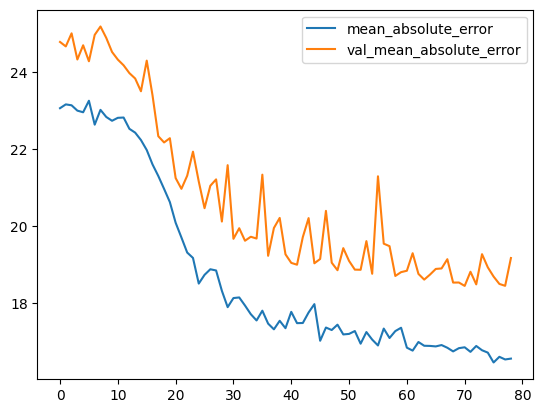

52/52 [==============================] - 10s 195ms/step - loss: 710.5801 - mean_absolute_error: 16.5555 - val_loss: 878.6633 - val_mean_absolute_error: 19.1709
Epoch 80/100
52/52 [==============================] - ETA: 0s - loss: 690.5579 - mean_absolute_error: 16.5495
Epoch 80: val_mean_absolute_error did not improve from 18.44598


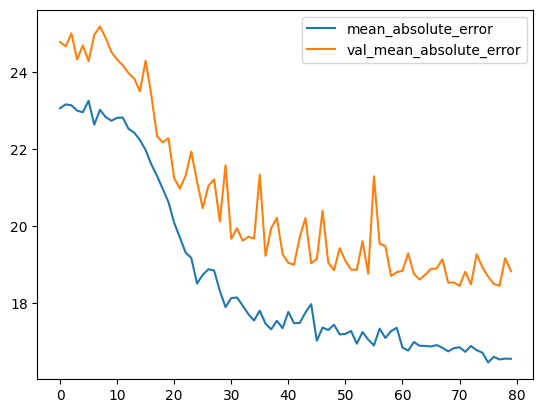

52/52 [==============================] - 10s 196ms/step - loss: 690.5579 - mean_absolute_error: 16.5495 - val_loss: 871.1601 - val_mean_absolute_error: 18.8272
Epoch 81/100
52/52 [==============================] - ETA: 0s - loss: 705.0659 - mean_absolute_error: 16.5889
Epoch 81: val_mean_absolute_error did not improve from 18.44598


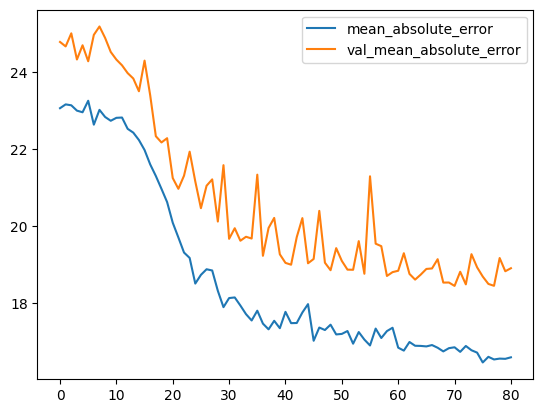

52/52 [==============================] - 10s 195ms/step - loss: 705.0659 - mean_absolute_error: 16.5889 - val_loss: 869.2723 - val_mean_absolute_error: 18.9058
Epoch 82/100
52/52 [==============================] - ETA: 0s - loss: 695.0594 - mean_absolute_error: 16.7005
Epoch 82: val_mean_absolute_error did not improve from 18.44598


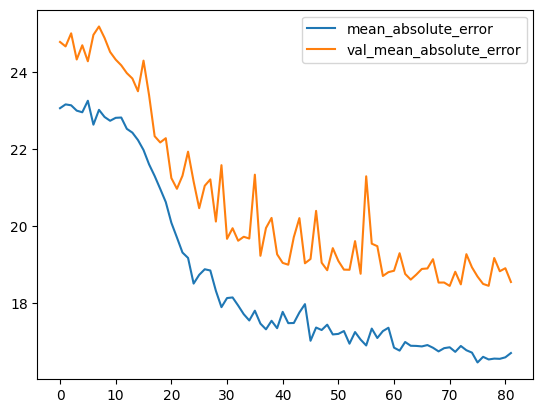

52/52 [==============================] - 10s 195ms/step - loss: 695.0594 - mean_absolute_error: 16.7005 - val_loss: 869.2975 - val_mean_absolute_error: 18.5477
Epoch 83/100
52/52 [==============================] - ETA: 0s - loss: 705.4321 - mean_absolute_error: 16.5805
Epoch 83: val_mean_absolute_error improved from 18.44598 to 18.31969, saving model to temp-from-pre.keras


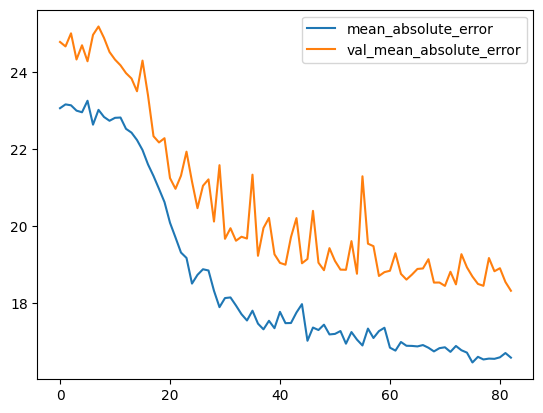

52/52 [==============================] - 11s 212ms/step - loss: 705.4321 - mean_absolute_error: 16.5805 - val_loss: 888.1799 - val_mean_absolute_error: 18.3197
Epoch 84/100
52/52 [==============================] - ETA: 0s - loss: 705.7430 - mean_absolute_error: 16.4868
Epoch 84: val_mean_absolute_error did not improve from 18.31969


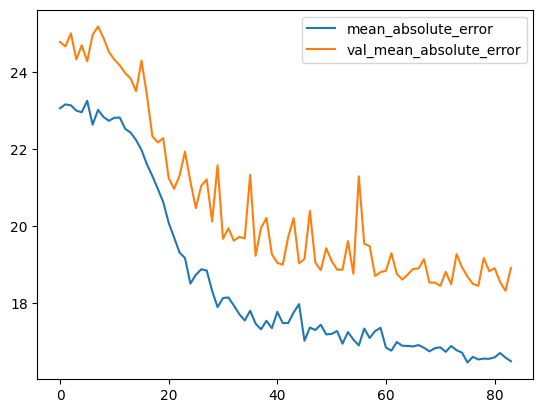

52/52 [==============================] - 10s 196ms/step - loss: 705.7430 - mean_absolute_error: 16.4868 - val_loss: 866.0844 - val_mean_absolute_error: 18.9118
Epoch 85/100
52/52 [==============================] - ETA: 0s - loss: 699.2309 - mean_absolute_error: 16.5289
Epoch 85: val_mean_absolute_error improved from 18.31969 to 18.23816, saving model to temp-from-pre.keras


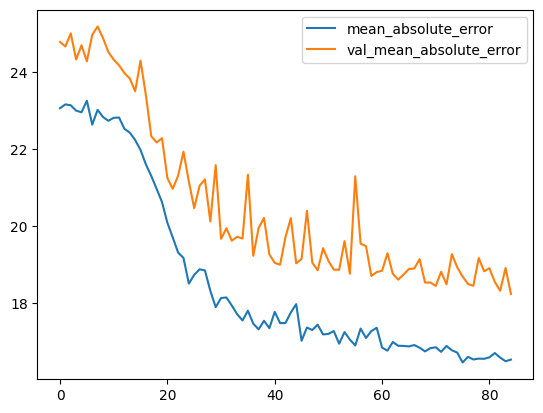

52/52 [==============================] - 11s 216ms/step - loss: 699.2309 - mean_absolute_error: 16.5289 - val_loss: 912.0692 - val_mean_absolute_error: 18.2382
Epoch 86/100
52/52 [==============================] - ETA: 0s - loss: 744.9642 - mean_absolute_error: 17.0779
Epoch 86: val_mean_absolute_error did not improve from 18.23816


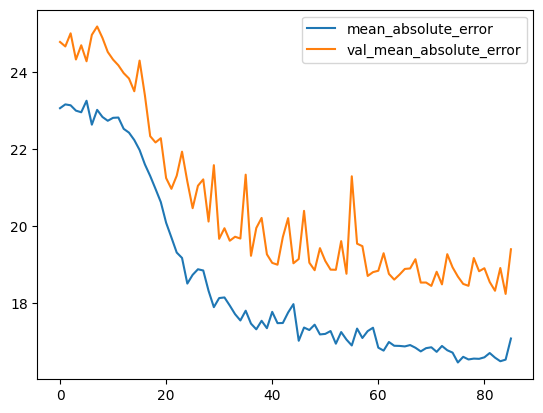

52/52 [==============================] - 10s 194ms/step - loss: 744.9642 - mean_absolute_error: 17.0779 - val_loss: 877.7596 - val_mean_absolute_error: 19.3985
Epoch 87/100
52/52 [==============================] - ETA: 0s - loss: 695.0144 - mean_absolute_error: 16.4948
Epoch 87: val_mean_absolute_error did not improve from 18.23816


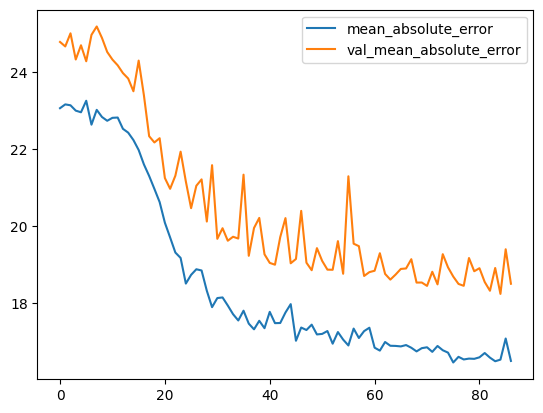

52/52 [==============================] - 10s 195ms/step - loss: 695.0144 - mean_absolute_error: 16.4948 - val_loss: 859.8493 - val_mean_absolute_error: 18.5021
Epoch 88/100
52/52 [==============================] - ETA: 0s - loss: 695.2036 - mean_absolute_error: 16.5592
Epoch 88: val_mean_absolute_error did not improve from 18.23816


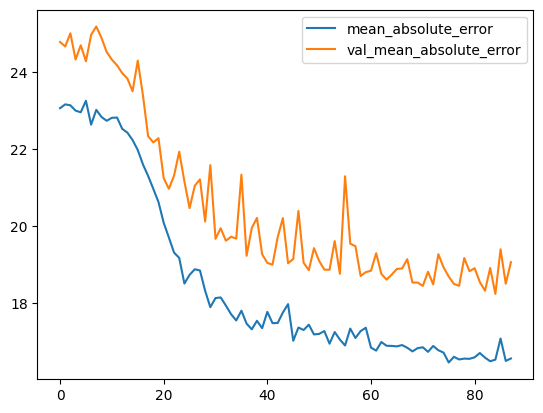

52/52 [==============================] - 10s 194ms/step - loss: 695.2036 - mean_absolute_error: 16.5592 - val_loss: 865.2173 - val_mean_absolute_error: 19.0641
Epoch 89/100
52/52 [==============================] - ETA: 0s - loss: 699.0090 - mean_absolute_error: 16.5519
Epoch 89: val_mean_absolute_error did not improve from 18.23816


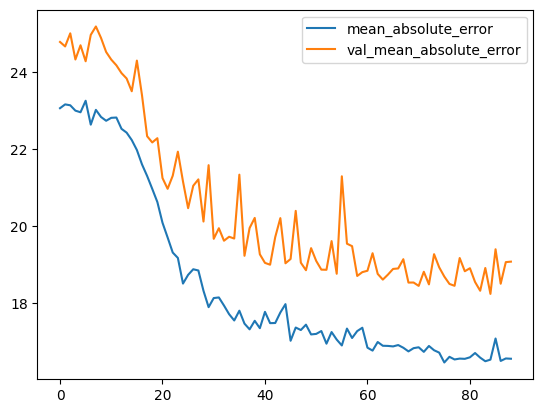

52/52 [==============================] - 10s 195ms/step - loss: 699.0090 - mean_absolute_error: 16.5519 - val_loss: 866.2672 - val_mean_absolute_error: 19.0768
Epoch 90/100
52/52 [==============================] - ETA: 0s - loss: 682.7910 - mean_absolute_error: 16.3508
Epoch 90: val_mean_absolute_error did not improve from 18.23816


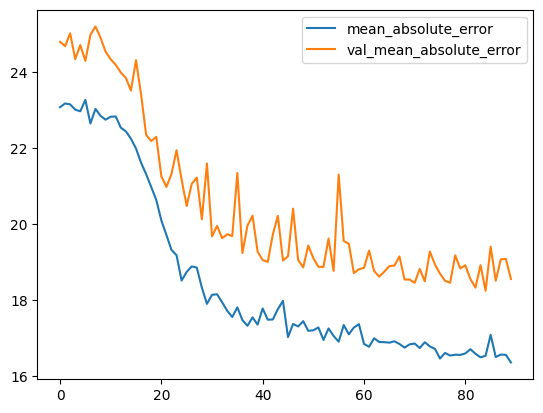

52/52 [==============================] - 10s 195ms/step - loss: 682.7910 - mean_absolute_error: 16.3508 - val_loss: 854.1699 - val_mean_absolute_error: 18.5470
Epoch 91/100
52/52 [==============================] - ETA: 0s - loss: 695.6066 - mean_absolute_error: 16.7552
Epoch 91: val_mean_absolute_error did not improve from 18.23816


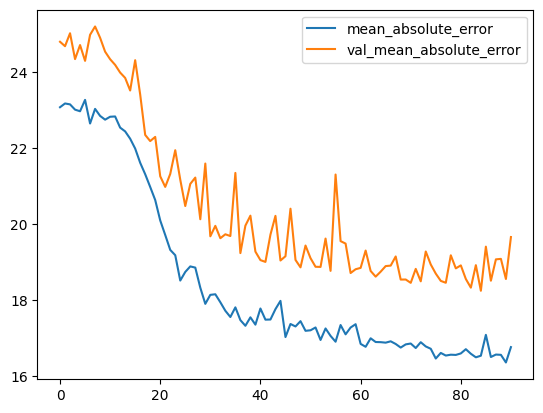

52/52 [==============================] - 10s 195ms/step - loss: 695.6066 - mean_absolute_error: 16.7552 - val_loss: 889.8751 - val_mean_absolute_error: 19.6514
Epoch 92/100
52/52 [==============================] - ETA: 0s - loss: 706.6235 - mean_absolute_error: 16.5172
Epoch 92: val_mean_absolute_error did not improve from 18.23816


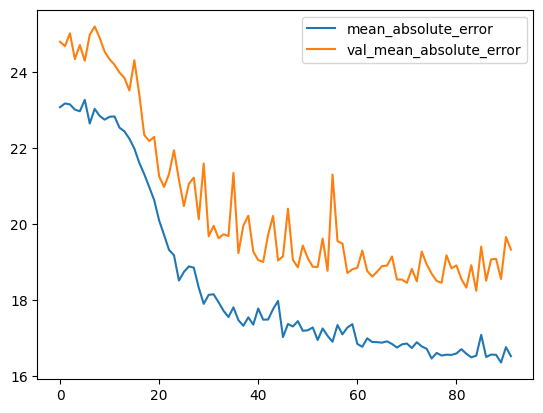

52/52 [==============================] - 10s 196ms/step - loss: 706.6235 - mean_absolute_error: 16.5172 - val_loss: 867.0751 - val_mean_absolute_error: 19.3203
Epoch 93/100
52/52 [==============================] - ETA: 0s - loss: 709.5389 - mean_absolute_error: 16.5350
Epoch 93: val_mean_absolute_error did not improve from 18.23816


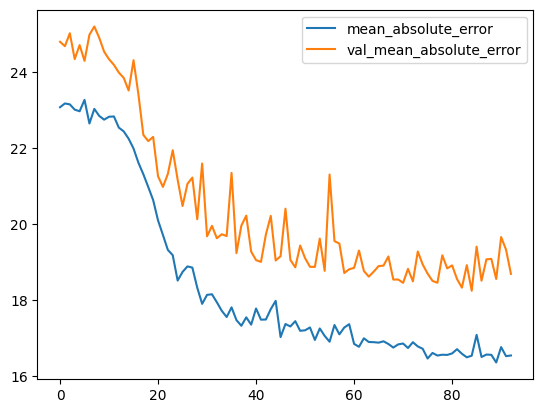

52/52 [==============================] - 10s 195ms/step - loss: 709.5389 - mean_absolute_error: 16.5350 - val_loss: 849.8383 - val_mean_absolute_error: 18.6826
Epoch 94/100
52/52 [==============================] - ETA: 0s - loss: 719.2297 - mean_absolute_error: 16.7532
Epoch 94: val_mean_absolute_error did not improve from 18.23816


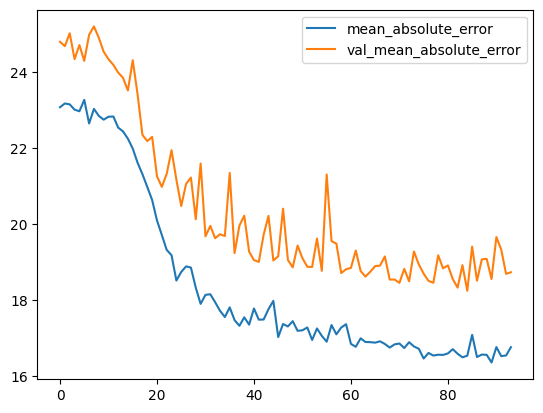

52/52 [==============================] - 10s 195ms/step - loss: 719.2297 - mean_absolute_error: 16.7532 - val_loss: 850.2391 - val_mean_absolute_error: 18.7246
Epoch 95/100
52/52 [==============================] - ETA: 0s - loss: 701.0328 - mean_absolute_error: 16.5160
Epoch 95: val_mean_absolute_error did not improve from 18.23816


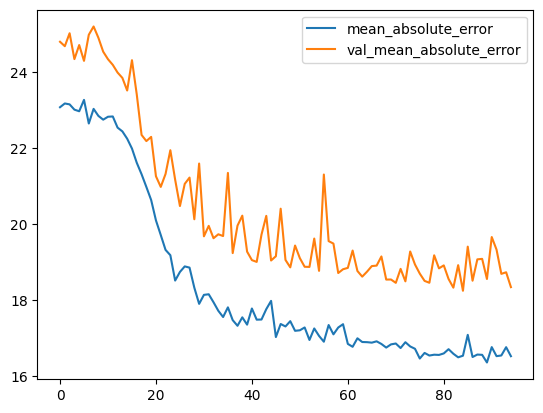

52/52 [==============================] - 10s 195ms/step - loss: 701.0328 - mean_absolute_error: 16.5160 - val_loss: 853.1367 - val_mean_absolute_error: 18.3336
Epoch 96/100
52/52 [==============================] - ETA: 0s - loss: 696.9458 - mean_absolute_error: 16.5177
Epoch 96: val_mean_absolute_error improved from 18.23816 to 18.11798, saving model to temp-from-pre.keras


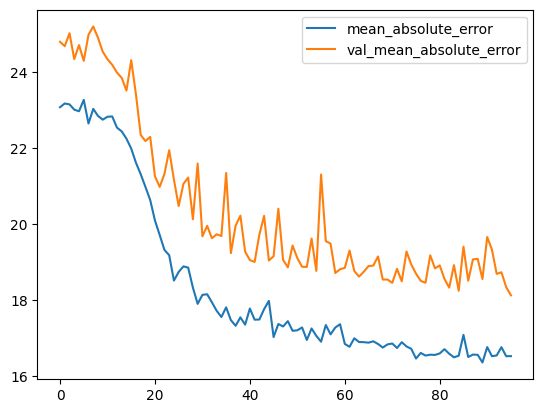

52/52 [==============================] - 11s 216ms/step - loss: 696.9458 - mean_absolute_error: 16.5177 - val_loss: 880.6135 - val_mean_absolute_error: 18.1180
Epoch 97/100
52/52 [==============================] - ETA: 0s - loss: 701.2990 - mean_absolute_error: 16.5050
Epoch 97: val_mean_absolute_error did not improve from 18.11798


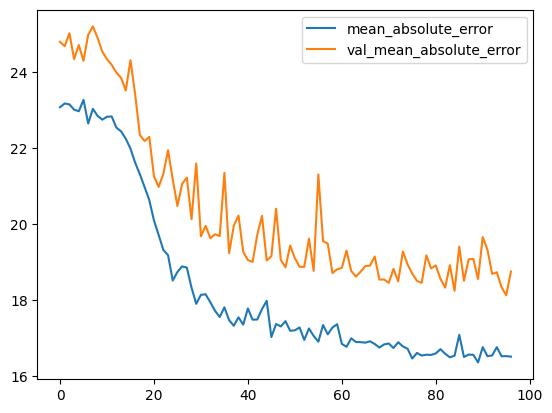

52/52 [==============================] - 10s 199ms/step - loss: 701.2990 - mean_absolute_error: 16.5050 - val_loss: 845.1696 - val_mean_absolute_error: 18.7454
Epoch 98/100
52/52 [==============================] - ETA: 0s - loss: 684.7333 - mean_absolute_error: 16.2687
Epoch 98: val_mean_absolute_error did not improve from 18.11798


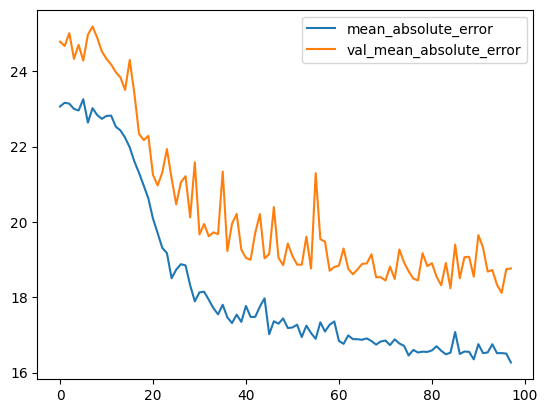

52/52 [==============================] - 10s 195ms/step - loss: 684.7333 - mean_absolute_error: 16.2687 - val_loss: 844.0662 - val_mean_absolute_error: 18.7658
Epoch 99/100
52/52 [==============================] - ETA: 0s - loss: 682.1647 - mean_absolute_error: 16.3641
Epoch 99: val_mean_absolute_error did not improve from 18.11798


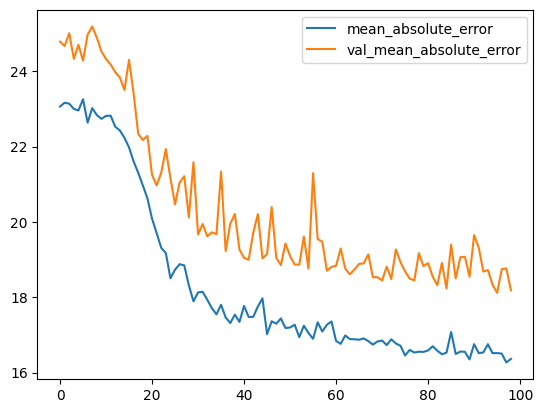

52/52 [==============================] - 10s 199ms/step - loss: 682.1647 - mean_absolute_error: 16.3641 - val_loss: 922.7244 - val_mean_absolute_error: 18.1885
Epoch 100/100
52/52 [==============================] - ETA: 0s - loss: 709.6140 - mean_absolute_error: 16.5349
Epoch 100: val_mean_absolute_error did not improve from 18.11798


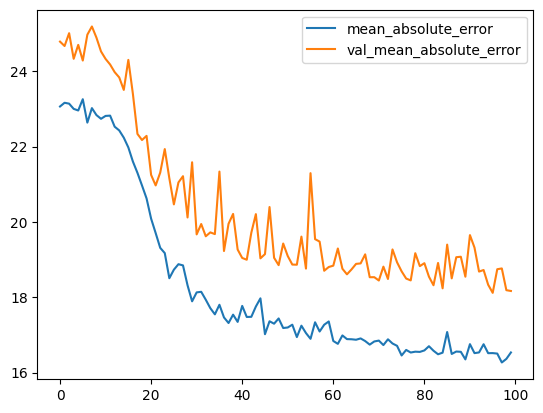

52/52 [==============================] - 10s 199ms/step - loss: 709.6140 - mean_absolute_error: 16.5349 - val_loss: 850.5017 - val_mean_absolute_error: 18.1676


In [11]:
# Train the Model
model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, plot_losses],
)

In [12]:
from keras.models import load_model

# Test Model
# model = load_model("temp-from-pre.keras")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 10, 16, 2048)      23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                             

In [13]:
validation_generator.reset()
predict = model.predict(
    x=validation_generator,
    steps=len(validation_generator),
    workers=1,
    use_multiprocessing=False,
)

val_set = validation_set.copy()
val_set["meat"] = predict[:, 0]
val_set["veggie"] = predict[:, 1]
val_set["noodle"] = predict[:, 2]
val_set.compare(validation_set)

12/12 [==============================] - 3s 150ms/step


meat           veggie            noodle      
           self other       self other        self other
1574   4.831488     0  10.739642     0   32.911495   107
1523   6.852001     0  14.507159    55   50.152065    93
1165   0.929239    11   3.458233     0   -0.450620     0
970    9.509489     6  19.452320     4   72.749489    88
141   24.228781    30  46.974087    37  198.038788   165
...         ...   ...        ...   ...         ...   ...
1774   3.288605    16   7.859500    11   19.719236     0
1793   7.606876     0  15.916955    13   56.593090    88
729    5.804997     2  12.542916    37   41.127064    54
302   12.361565     0  24.793968     5   97.134140   146
1711  10.095150     0  20.566511    79   77.845245     0

[372 rows x 6 columns]

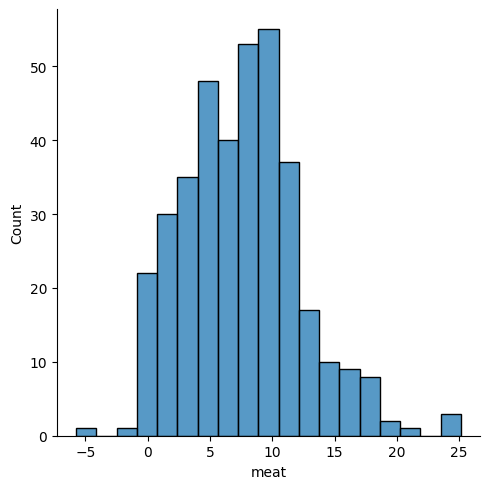

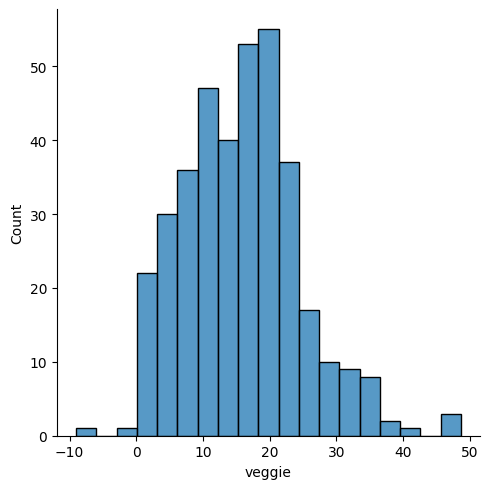

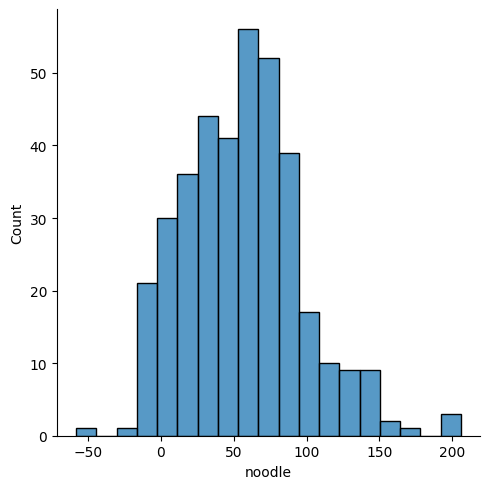

In [14]:
import seaborn as sns

sns.displot(val_set, x="meat")
sns.displot(val_set, x="veggie")
sns.displot(val_set, x="noodle")

In [15]:
(val_set["meat"] - validation_set["meat"]).abs().mean()

6.979058372527762

In [16]:
(val_set["veggie"] - validation_set["veggie"]).abs().mean()

13.124687186332158

In [17]:
(val_set["noodle"] - validation_set["noodle"]).abs().mean()

34.399115953314045